# Dataset preparation and partitioning

This notebook is structured in two parts:
- The first part shows how to solve the hackathon task optimally using Chains Of Seasonality framework
- In the second part I show how the framework deals with a more real-worldish problem that doesn't revolve around befittng some metrics

The task was to forecast multiple $(153*9=1377)$ time-series of hourly frequency for the first quarter of 2021, given data for previous 2 years, thus yielding $90*24=2160$ data points to predict for each time-series. Each data point represents a number of calls to an ambulance service in one of the Russia's megapolices for a particular type of reason (which I from now on refer to as a "disease") in a particular zone of the city at a particular hour.
In order to participate in the track of this task we had to sign an NDA, so, unfortunately, I won't show the names of the diseases and zones and relation to their values.

The distinctive futures of the data are:
- It's quite sparse with majority of stand-alone zone values being zeros for most diseases
- It exhibits multiple types of seasonality (with periods each 24 hours, 7 days, and yearly) and often a singly time-series contains all of them

In [2]:
import pandas as pd
import numpy as np
from columns_data import cols

In [3]:
df = pd.read_csv('icl_train.csv', index_col='date' )

In [ ]:
# It's necessary to set index to period to be compliant with seasonality framework
# We set columns in the right order which is used for calculation of weighted metrics
df = df[['zone']+ cols]
df = df.set_index(
    pd.PeriodIndex(df.index, freq='h')
)
df.head(10)

The dataset contains data about 153 causes for a call to an ambulance in 9 zones of one Russian big city during 2019 and 2020 years

In [5]:
ZONE = "zone"
ZONES_NAMES = df[ZONE].unique()
ZONES_CNT=len(ZONES_NAMES)
TIME = 'date'
DISEASES = df.columns[1:].values.tolist()
DISEASE_CNT = len(DISEASES)
print('Zones count:', ZONES_CNT) 
print('Diseases count:', DISEASE_CNT)


Zones count: 9
Diseases count: 153


In [6]:
# Additional indexing of the dataset by zones 
df = df.set_index(ZONE, append=True)

In [7]:
# Preprocessing - filling missing hours in the beginning of 2020 by 
# counterparts in 2021
dfs_zoned = [df.loc[(slice(None), zone), ] for zone in ZONES_NAMES]
full_index = pd.period_range(start='2019-01-01 00:00', end='2020-12-31 23:00', freq='h')
for i in range(ZONES_CNT):
  dfs_zoned[i] = dfs_zoned[i].reset_index(level=1, drop=True)
  dfs_zoned[i] = dfs_zoned[i].reindex(full_index)
  for j in range(10):
    if dfs_zoned[i].iloc[j, :].isnull().values.any():
      index_to_fetch_from = pd.Period(
          dfs_zoned[i].index[j].start_time + pd.DateOffset(years=1),
          'h'
      )
      dfs_zoned[i].iloc[j, :] = dfs_zoned[i].loc[index_to_fetch_from, :]
  #print(dfs_zoned[i].head())

Creation of infrastructure for pipeline' operations. Class Dataset encompasses all zone datasets and total one summarizing them to get city-wide total number of calls for a disease, for some frequency period.
 
In the beginning of the cell I listed all frequencies that could have been potentially useful for the task

In [8]:

freqs = [
    'h', '2h', '4h', '8h', 
    'd', 'w', '2w', 
    'm', '2m', 'q', 'y', '2y'
]
class Dataset:
  """
  frequency: frequency of the dataset
  zones: list of zones' datasets
  total: dataset of zones sum (city total)
  """
  def __init__(self, frequency):
    self.frequency = frequency
    self.zones = []
    self.ZONES_NAMES = ZONES_NAMES
    self.DISEASES = DISEASES
    for i in range(ZONES_CNT):
      self.zones.append(
          dfs_zoned[i].resample(self.frequency).sum()
      )
    self.total = sum(self.zones)
    # It was planned to also use clasterized feautures but 
    # there wasn't enough time for that
    # self.cl_zones = ...
    # self_cl_total =  ...

ds = {freq: Dataset(freq) for freq in freqs}


Examples of usage:

ds['m'].zones[3][DISEASES[50]]

ds['h'].total

# Seasonal Models Introduction

In [9]:
from tsmodels import UniformModel, SeasonalModel
from chains import ChainedModels, CrossValChain

## Example of the use of a simple chain of seasonality

In [10]:
disease = DISEASES[0]
# Initialise and train all seasonal models which you want to add 
# to the chain.
seas_m = SeasonalModel('m')
seas_m.train(ds['m'].total[disease])
seas_h = SeasonalModel('h')
seas_h.train(ds['h'].total[disease])
# Uniform models don't need to be pretrained.
models = [
        UniformModel('y'), seas_m, UniformModel('w'), seas_h
]

chain = ChainedModels(
        chain_of_models=models,
        input_ts=ds['2y'].total[disease])
# Or you can manually train all models in chain at once.
# But this won't give you flexibility to train different seasonality 
# models on different subperiods of ts of interest
# chain.train(ds['h'].total[disease])

# Prediction is based on input_ts, thus a single value which describes total 
# for 2 years gets divided into 2 equal yearly values. Each of them, in turn, gets converted 
# into 12 monthly UNequal (because monthly model is seasonal) values. Each of the monthly values 
# is uniformly upsampled to weekly basis and then, finally, converted to hourly data with use
# of seasonality
chain.predict()
# 24*92 is last quarter in hours
chain.prediction_mae(
    ds['h'].total[DISEASES[0]], last_periods=24*92
    )

3.2499881988658936

## Example of the use of cross-validated seasonality chain

In [12]:
models = [
        UniformModel('y'), seas_m, UniformModel('w'), seas_h
]
# input_ts in cross-validated chain is used for ARMA/martingale based prediction
# of next period of length equal to step, and also for cross-validation:
# The model repeatedly trains seasonality coefficients based on the data of 4 past 
# quarters and predicts a series for one step (a quarter) ahead using  mean of 
# last two quarters as baseline prediction. Then starting point moves one step
# further and the process gets repeated
cv_chain = CrossValChain(
                chain_of_models=models, input_ts=ds['q'].total[disease],
                train_period=4, ar_period=2, 
                step=pd.DateOffset(months=3),
                train_ts=ds['h'].total[disease], 
                calc_func=SeasonalModel.get_median_weights
            )
test_start = pd.Timestamp('2020-01')
test_stop = pd.Timestamp('2020-12')            
cv_chain.predict(test_start, test_stop)    
print(cv_chain.description())
print(cv_chain.prediction_mae(ds['h'].total[disease]))        

Training period: 4,     AR (martingale) period: 2, step: <DateOffset: months=3>     models: ['UniformModel y', 'SeasonalModel m', 'UniformModel w', 'SeasonalModel h']
5.391925782361269


# Getting best solution for the contest task

In [10]:
# Library of zones
# Not all this code has been actually deployed
class Zone():
    def __init__(self, number):
        self.number = number

l_zones = [Zone(i) for i in range(ZONES_CNT)]

percents = list()
avg_percents = list()
for df_zoned in ds['d'].zones:
    percent = df_zoned/ds['d'].total
    percents.append(percent)
    # Average zone share (percent) of city total for each disease
    avg_percents.append(percent.mean())#.to_frame().T)

for i in range(ZONES_CNT):
    # Calculating average share of city total of all diseases in the current zone
    # It can be interpreted as a scale of the zone in relation to the whole city
    l_zones[i].avg_scale = avg_percents[i].mean()
    # Adding average shares for each of the individual diseases
    l_zones[i].ind_scales = avg_percents[i]
    # Calculating absilute percent differences
    l_zones[i].diff_from_av = \
        (l_zones[i].ind_scales/l_zones[i].avg_scale - 1).abs()
    # Calculating ratio of deviation of zone percentage to its 
    # average with time for each diseases (variance ratio)
    l_zones[i].var_ratios = percents[i].mad() / avg_percents[i]


## One of the earliest pipelines which I developed still during contest

This pipeline wasn't first but turned out to be the last which I managed to create till the end of the contest. It didn't employ cross-validation but used a nascent form of martingale/AR model: the value for the highest level forecast of 4Q2020 time-series was the actual value of 3Q2020. And the best model was selected by MAE of 4Q2020

It didn't round predictions to integer numbers which turned out to be crucial for MAE metrics.

In [40]:
# A pipeline for forecasting a city total numbers of calls for a disease and further transformation to zone levels
# Incomplete and imperfect
import time
import multiprocessing
class PipelineTotal():
  def __init__(self, disease):
    self.disease = disease
    # Trainig the seasonal models (that are building blocks for the chains)
    #train_start = '2020-7'
    #train_stop = '2020-9'
    train_start = '2019-01'
    train_stop = '2020-12'
          
    self.seas_h = SeasonalModel('h')
    self.seas_h.train(ds['h'].total[disease][train_start:train_stop])
    self.seas_2h = SeasonalModel('2h')
    self.seas_2h.train(ds['2h'].total[disease][train_start:train_stop])
    self.seas_4h = SeasonalModel('4h')
    self.seas_4h.train(ds['4h'].total[disease][train_start:train_stop])
    self.seas_8h = SeasonalModel('8h')
    self.seas_8h.train(ds['8h'].total[disease][train_start:train_stop])
    self.seas_d = SeasonalModel('d')
    self.seas_d.train(ds['d'].total[disease][train_start:train_stop])
    self.seas_m = SeasonalModel('m')
    self.seas_m.train(ds['m'].total[disease][train_start:train_stop])
    self.seas_q = SeasonalModel('q')
    self.seas_q.train(ds['q'].total[disease][train_start:train_stop])
    # Building chains
    self.chains = []
    test_ds = ds['q'].total[disease].copy()
    test_ds[-1] = test_ds[-2]

    self.chains.append(ChainedModels(#0
      [self.seas_m, UniformModel('w'), self.seas_h],
      test_ds                   
    ))
    self.chains.append(ChainedModels(#1
      [self.seas_m, UniformModel('w'), self.seas_2h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(#2
      [self.seas_m, UniformModel('w'), self.seas_4h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(#3
      [ self.seas_m, UniformModel('w'), self.seas_8h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(#4
      [ self.seas_m, UniformModel('w'), self.seas_d, self.seas_h],
      test_ds                   
    ))
    self.chains.append(ChainedModels(#5
      [UniformModel('w'), self.seas_h],
      test_ds                   
    ))
    self.chains.append(ChainedModels(
      [UniformModel('w'), self.seas_2h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(
      [UniformModel('w'), self.seas_4h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(
      [UniformModel('w'), self.seas_8h, UniformModel('h')],
      test_ds                   
    ))
    self.chains.append(ChainedModels(
      [UniformModel('w'), self.seas_d, self.seas_h],
      test_ds                   
    ))
    # 24*92 is last quarter of 2020 in hours
    l_periods = 24*92
    for cnt, chain in enumerate(self.chains):
      #print(time.ctime(), 'started chain ', cnt)
      chain.predict()
      chain.prediction_mae(ds['h'].total[disease], last_periods=l_periods)

    metrics = [chain.mae for chain in self.chains]
    self.best_index = np.argmin(metrics)
    self.best_mae = metrics[self.best_index]
    self.best_chain = self.chains[self.best_index]

    self.contest_mae = 0
    for i in range(ZONES_CNT):
      zone_prediction = self.best_chain.prediction * l_zones[i].ind_scales[disease]
      self.contest_mae += (zone_prediction - 
                           ds['h'].zones[i][disease]).\
                           abs()[-l_periods:].mean() / ZONES_CNT

    #print(self.contest_mae, self.best_index, disease)
    dataframes = []
    input_for_pred_val = ds['q'].total[disease]['4Q2020']
    input_for_pred_ind = pd.Period(
       pd.Timestamp('2021-01-01 00:00:00'), 'y')
    input_for_pred = pd.Series(input_for_pred_val, index=[input_for_pred_ind])
    pred_chain = ChainedModels(
        chain_of_models=self.best_chain.models, 
        input_ts = input_for_pred
        )
    base_prediction = pred_chain.predict()['1Q2021']
    for i in range(ZONES_CNT):
      dataframes.append( base_prediction * l_zones[i].ind_scales[disease])
      dataframes[i] = dataframes[i].to_frame(). \
      set_index(keys=pd.Index([ZONES_NAMES[i]]*len(dataframes[i])), append=True)
      dataframes[i].index.names=['date', 'zone']
      dataframes[i].columns = [self.disease] 
      values_to_drop = pd.period_range(start='2021-03-31 01:00:00', 
                                      end='2021-03-31 23:00:00', freq='h')
      dataframes[i] = dataframes[i].drop(values_to_drop)

    self.q1_2021_pred = pd.concat(dataframes, axis=0)
    print(time.ctime(), self.contest_mae, self.best_index, disease, DISEASES.index(disease))


### Example of the use

In [41]:
%%time
test_pipe = PipelineTotal(DISEASES[0])
print(test_pipe.contest_mae, test_pipe.best_index)
print([m.name for m in test_pipe.best_chain.models])

Tue Jul  6 15:26:07 2021 0.7545734369260608 5 0
0.7545734369260608 5
['UniformModel w', 'SeasonalModel h']
CPU times: user 1.82 s, sys: 24.3 ms, total: 1.84 s
Wall time: 1.83 s


<AxesSubplot:title={'center':'24HOURS SEASONALITY'}>

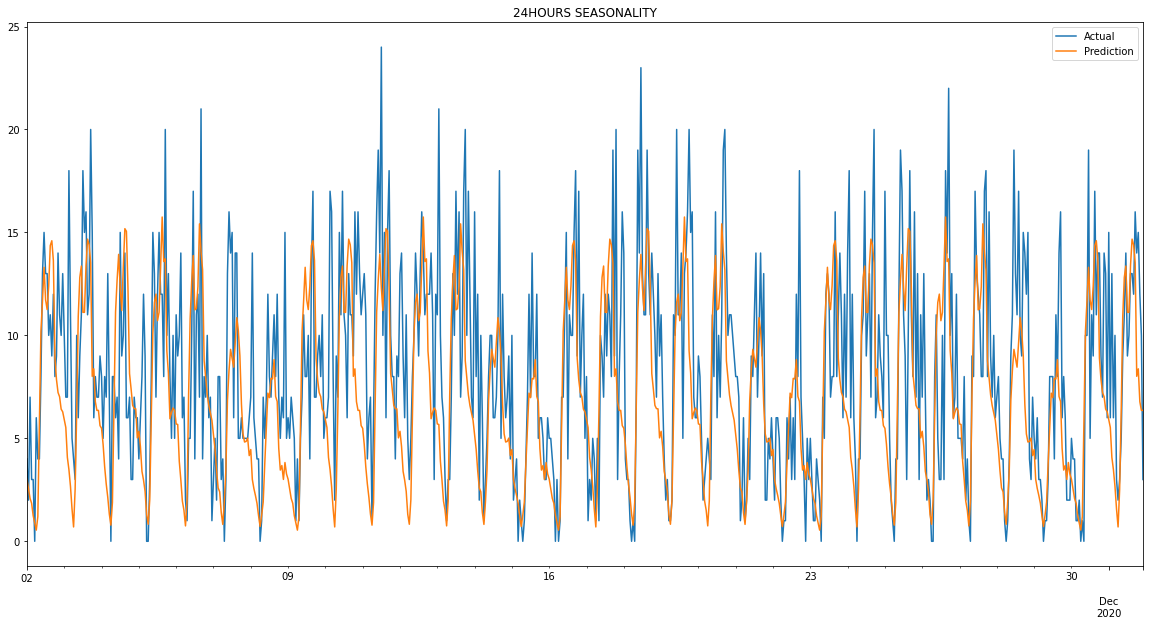

In [46]:
offset = -720*2
my_chain = test_pipe.best_chain
my_chain.predict()
truth = ds['h'].total[DISEASES[0]].rename('Actual')
my_pred = my_chain.prediction.rename('Prediction')
pd.concat([truth, my_pred], axis=1)[offset:720+offset-1].plot(figsize=(20, 10), title='24HOURS SEASONALITY')

Based on the graph it seems that this relatively simple pipe gives decent predictions for a city-wide number of a disease call occurencies. But what about contest score?

### Results of the model
Training 2019-2020, ar(1) 2020q3  for test of 2020q4, mean seasonality, prediction by 2020q4, validation last 3 months, in-sample score 1.517, out-of sample score 1.119 or 1.03 fully rounded

In [ ]:
predictions = []
for disease in DISEASES:
  predictions.append(PipelineTotal(disease))

The metrics for the contest was weighted sum of MAEs for each of the diseases with first diseases having unproportionally more weight

In [57]:
scores = [pred.contest_mae for pred in predictions]
total_score = sum([scores[i]/(i+1) for i in range(len(scores))])
print(total_score)

This intermidiate result achieved third place by jury's scores despite  having relatively lower metrics value than the best scoring one (apparently for the concept and implementation).

But later I realized that the data (number of calls to ambulance service) was integer numbers, and it also was quite sparse, with majority of values beeing 0s. My model at first was giving out decimals, which is right for predicting *average* value given some condiditon but fails if your task is  to predict most probable integer number of calls to occur.

Which approach is best for real-life scenario is another topic of discussion that I will adress later.

So I rounded predictions to integers and that drastically improved score to 1.03. Resulting outputs were mostly all zeros except a few first diseases.

Also note that I made a mistake and used 4Q2020 total to predict whole 2021 year, effectively dividing input value by 4 (lines 94-96). It resulted in an advantegeous score and I'll explain why later.

## Final version of the pipeline for city total based predictions

This pipeline uses one step ahead walk-forward cross-validation, and in addition to choosing best performing chain of seasonal models it optimizes the lengths of windows for calculation of seasonality indices and for ARMA/martingale prediction of the next lowest-frequency value of predicted time-series.

It also rounds all predictions to integers and chooses best combination of parameters by looking at contest metrics value over training set, which accounts for individual zones rather than crude mae comparing unrounded predictions for city total to city total actuals.  
As it churns through a lot more variants of chains, it employs multiprocessing type of parallerism. n_processes = 16 is the number of threads in my computer's CPU, and I advice you to adjust it to your appropriate value.

In [17]:

# Pipeline to achieve the best forecast for some disease (city total) and further partition it
#  by zone
import time
from itertools import product, chain as list_concat
from joblib import Parallel, delayed
class PipelineTotal():
    """
    Pipeline for cross-validation and selection of best chain of seasonal 
    models along with train and test parameters
    """
    def __init__(self, disease):
        self.disease = disease

        step = pd.DateOffset(months=3)
        input_ts = ds['q'].total[disease]
        train_periods = [0, 1, 2, 4]
        ar_periods = [0, 1, 2, 4]

        #Components of chains:        
        component1 = (
            [SeasonalModel('q')], []
        ) 
        component2 = (
            [SeasonalModel('m')], []
        )   
        component3 = (
            [UniformModel('w')], []
        )
        component4 = (
            [SeasonalModel('h')], 
            [SeasonalModel('d'), SeasonalModel('h')],
            [SeasonalModel('2h'), UniformModel('h')],
            [SeasonalModel('4h'), UniformModel('h')],
            [SeasonalModel('8h'), UniformModel('h')]
        )
        self.chains = []
        for c1, c2, c3, c4, train_per, ar_per in product(
            component1, component2, component3, component4, train_periods, ar_periods
        ):
            self.chains.append(CrossValChain(
                chain_of_models=c1+c2+c3+c4, input_ts=input_ts,
                train_period=train_per, ar_period=ar_per, 
                step=step,
                train_ts=ds['h'].total[disease], 
                calc_func= SeasonalModel.get_experimental_weights
            ))
        test_start = pd.Timestamp('2020-01')
        test_stop = pd.Timestamp('2020-12')
        
        # Parallel cross-validation of all chains
        # Joblib copies all objects when creating child processes,
        # so no need to worry about shared concurrent access to same
        # seasonal and uniform models
        n_processes = 16
        # Overhead during start of new procceses if very big due to
        #  copying all models, so it's better to unite them in chunks
        chunks = [
            self.chains[z:z+n_processes] for z in 
            range(0, len(self.chains), n_processes)
        ]

        def get_contest_mae(chain, disease):
            contest_mae = 0
            for i in range(ZONES_CNT):
                zone_prediction = chain.prediction * l_zones[i].ind_scales[disease]
                zone_prediction = zone_prediction.round()
                contest_mae += (zone_prediction - 
                        ds['h'].zones[i][disease][zone_prediction.index.values]).\
                        abs().mean() / ZONES_CNT
            chain.contest_mae = contest_mae

        def envelope(chunk):
            for chain in chunk:
                chain.predict(test_start, test_stop)
                get_contest_mae(chain, disease)
                #chain.prediction_mae(ds['h'].total[disease])
            return chunk        
        start = time.time()
        res = Parallel(n_jobs=n_processes)( delayed(envelope)
        (z) for z in chunks)
        self.chains = list(list_concat(*res))
        #print(res[:5])
        """
        # Cross-validation of all chains (sequential)
        for cnt, chain in enumerate(self.chains):
            if cnt% 50 ==0: print(time.ctime(), 'started chain ', cnt)
            chain.predict(test_start, test_stop)
            chain.prediction_mae(ds['h'].total[disease])
        """
        self.chains.sort(key= lambda x: x.contest_mae)
        metrics = [chain.contest_mae for chain in self.chains]
        self.best_index = np.argmin(metrics)
        #self.best_mae = metrics[self.best_index]
        self.best_chain = self.chains[self.best_index]

        self.contest_mae = self.best_chain.contest_mae
        self.chains = self.chains[:20]
        #print(self.contest_mae, self.best_index, disease)

        # Getting predictions for 1q2021
        pred_start = pd.Timestamp('2021-01-01 00:00:00')
        pred_end = pd.Timestamp('2021-04-01 00:00:00')
        base_prediction = self.best_chain.predict(pred_start, pred_end)['1Q2021']
        
        values_to_drop = pd.period_range(start='2021-03-31 01:00:00', 
                                        end='2021-03-31 23:00:00', freq='h')
        base_prediction = base_prediction.drop(values_to_drop)     
                              
        dataframes = []

        for i in range(ZONES_CNT):
            dataframes.append( base_prediction * l_zones[i].ind_scales[disease])
            dataframes[i] = dataframes[i].to_frame(). \
            set_index(keys=pd.Index([ZONES_NAMES[i]]*len(dataframes[i])), append=True)
            dataframes[i].index.names=['date', 'zone']
            dataframes[i].columns = [self.disease] 


        self.q1_2021_pred = pd.concat(dataframes, axis=0).round()
        print(time.ctime(), self.contest_mae, self.best_index, 
        disease, DISEASES.index(disease))


### An example of the use:

In [61]:
%%time
test_pipe = PipelineTotal(DISEASES[0])
print(test_pipe.contest_mae, test_pipe.best_index)
print(test_pipe.best_chain.description())
print(test_pipe.best_chain.models[-2].seasonal_weghts['w'])

Tue Jul  6 16:27:49 2021 0.5791337785873305 0 0
0.5791337785873305 0
Training period: 1,     AR (martingale) period: 4, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'SeasonalModel m', 'UniformModel w', 'SeasonalModel d', 'SeasonalModel h']
0    1.010398
1    1.128174
2    1.097181
3    1.047590
4    1.087882
5    0.898820
6    0.703559
dtype: float64
CPU times: user 4.3 s, sys: 1.89 s, total: 6.19 s
Wall time: 37.1 s


In [ ]:
print(([ch.contest_mae for ch in test_pipe.chains]))

### Results
Cross-validated quarterly optimised rounded values test, mean seasonality, saved as fully_r_submission4.csv, in-sample score 1.106, out-of-sample score 1.096

In [ ]:
predictions = []
for disease in DISEASES:
  predictions.append(PipelineTotal(disease))
  print(
      sum([predictions[i].contest_mae/(i+1) for i in range(len(predictions))])
  )

In [43]:
scores = [pred.contest_mae for pred in predictions]
total_score = sum([scores[i]/(i+1) for i in range(len(scores))])
print(len(scores))
print(total_score)

Cross-validated quarterly optimised rounded values test, median seasonality, in-sample score 1.101, out-sample score 1.048


It follows that introducing median-based indices of seasonality improves score significantly. In hindsight, it's unsurprising because median is the best estimator for MAE minimization (see this wiki article for a proof https://en.wikipedia.org/wiki/Mean_absolute_error#Proof_of_optimality), but there wasn't enoungh time to implement and test it: the contest lasted for less than 2 days.

The solution that I've liked the most for its fascinating simplicity and that had aquired second best score also used median values for predictions. But it predicted *raw* values using medians, not *seasonality indices* as in my case. In my framework, base prediction would stay the same representing *mean* value over some previous timespan, later being multiplied by median based seasonality ratio. The first approach might be superior and more robust in case of (seasonally) stationary time-series. But some diseases' time-series had regime switches and structural breaks over time, which can impact their temporal mean (or median) but leave seasonality unchanged. So it's better to separately evaluate seasonality and overall mean in my opinion. For a good example look at this graph:

<AxesSubplot:title={'center':'YEARLY SEASONALITY'}>

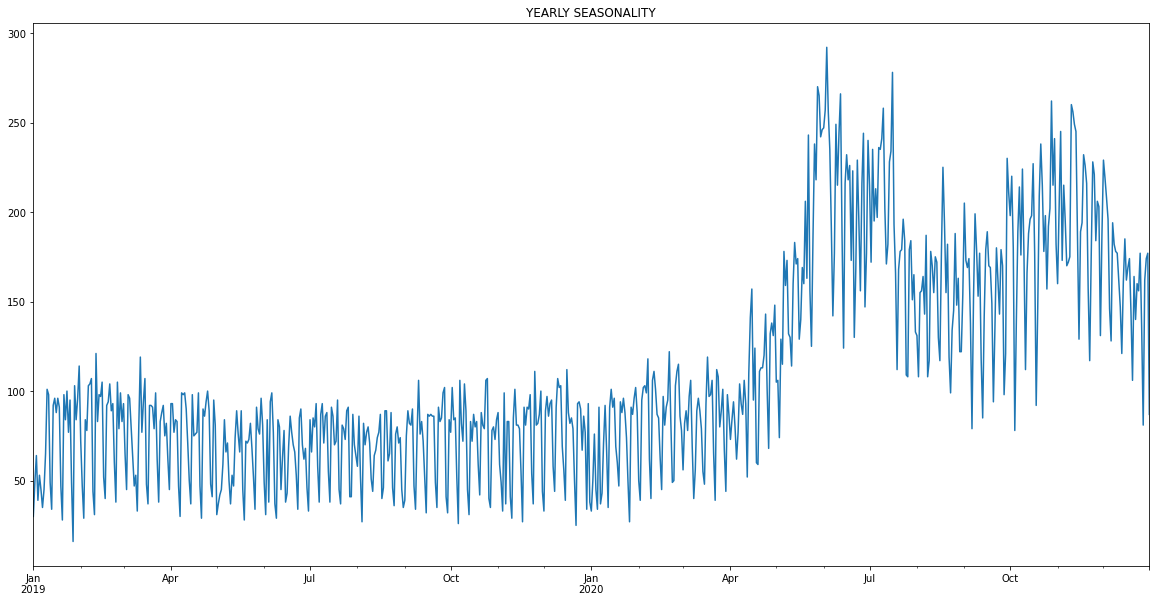

In [63]:
ds['d'].total[DISEASES[0]].plot(figsize=(20, 10), title='YEARLY SEASONALITY')

The graph also gives insight to why forecast of an imperfect pipeline with mean seasonality which mistakenly predicted a full year total by just one previous quarter value scored higher (1.031) than current state-of-the-art pipeline with median seasonality. It appears that first pipeline with reduced by a factor of 4 4Q2020 values better captured return to normalcy in 2021 after extraordinary events of 2020 linked to Covid pandemic. Big thanks to my fault that helped to highlight this!

It's also instructive to take a look on the graph of predicted vs actual values for best chain predictions: 

<AxesSubplot:title={'center':'24HOURS SEASONALITY'}>

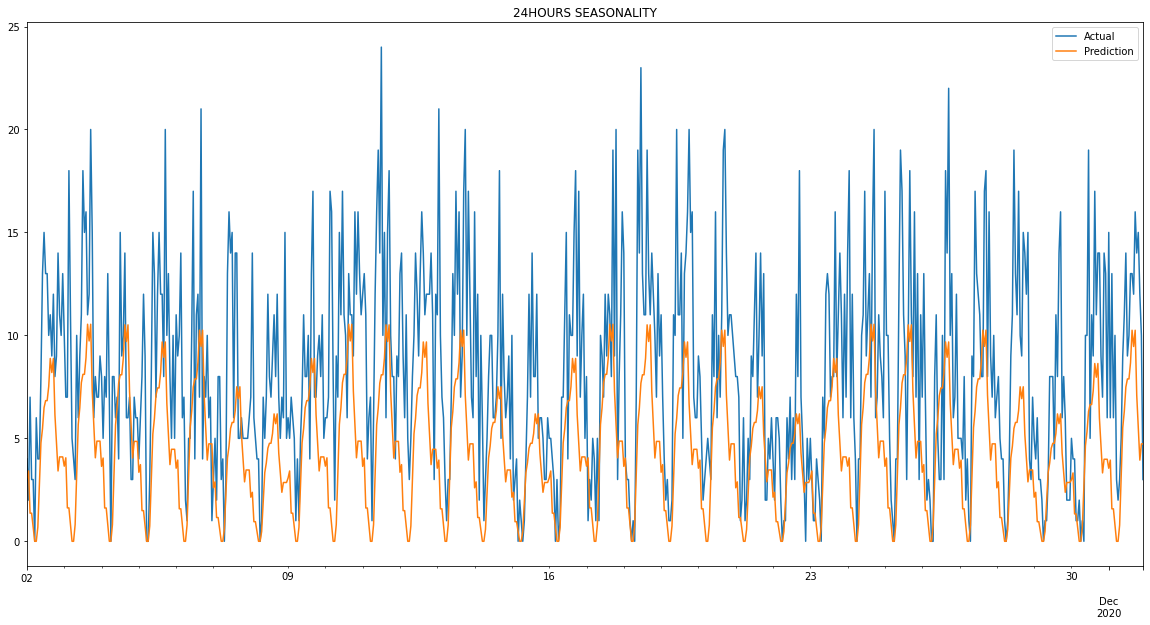

In [66]:
offset = -720*2
my_chain = test_pipe.best_chain
my_chain.predict(pd.Timestamp('2020-01'), pd.Timestamp('2021-01'))
truth = ds['h'].total[DISEASES[0]].rename('Actual')
my_pred = my_chain.prediction.rename('Prediction')
pd.concat([truth, my_pred], axis=1)[offset:720+offset-1].plot(figsize=(20, 10), title='24HOURS SEASONALITY')

It actually gives worse predictions, very poorly fitting reguraly occuring peaks of time-series even in-sample. Why does this happen?

Well, because of the sparsness of individual zones' series and properties of MAE metrics which favors zero predictions in these conditions. As a result, it underestimates the real city total but scores higher. 

Fun fact: in-sample score for all zeroes predictions is 1.204, out of sample is 1.081.

## Final pipeline for forecasting directly by zone

Taking advantage of the fact that almost all diseases except a few first ones yield all-zeros predictions, I've constructed iteratively improved a pipeline that forecasts disease occurencies directly by zone which should have output more accurate predictions.

The final version predicted 1Q2021 for three first deseases with bigger weights in contest metrics, calculating both seasonality and ARMA/Martingale values by 2019 data.

In [74]:
# Pipeline to forecast directly by zone
import time
from itertools import product, chain as list_concat
from joblib import Parallel, delayed
class PipelineZoned():
    """
    Pipeline for cross-validation and selection of best chain of seasonal 
    models along with train and test parameters
    """
    def __init__(self, zone_n, disease):
        self.disease = disease
        self.zone_n = zone_n
        step = pd.DateOffset(months=3)
        input_time_series = ds['q'].zones[zone_n][disease]
        train_periods = [0, 1, 2, 4]
        ar_periods = [0, 1, 2, 4]


        test_period_start = pd.Timestamp('2020-01')
        #Components of chains:
        """
        component1 = (
            [SeasonalModel('q')], []
        ) 
        """
        component2 = (
            [SeasonalModel('m')], []
        )   
        component3 = (
            [UniformModel('w')], []
        )
        component4 = (
            [SeasonalModel('h')], 
            [SeasonalModel('d'), SeasonalModel('h')],
            #[SeasonalModel('2h'), UniformModel('h')],
            #[SeasonalModel('4h'), UniformModel('h')],
            #[SeasonalModel('8h'), UniformModel('h')]
        )
        self.chains = []
        for  c2, c3, c4, train_per, ar_per in product(
             component2, component3, component4, train_periods, ar_periods
        ):
            self.chains.append(CrossValChain(
                chain_of_models=c2+c3+c4, input_ts=input_time_series,
                train_period=train_per, ar_period=ar_per, 
                step=step,
                train_ts=ds['h'].zones[zone_n][disease],
                calc_func=SeasonalModel.get_experimental_weights
            ))
        test_start = pd.Timestamp('2020-01')
        test_stop = pd.Timestamp('2021-01')
        
        # Parallel cross-validation of all chains
        # Joblib copies all objects when creating child processes,
        # so no need to worry about shared concurrent access to same
        # seasonal and uniform models
        n_processes = 16
        # Overhead during start of new procceses if very big due to
        #  copying all models, so it's better to unite them in chunks
        chunks = [
            self.chains[z:z+n_processes] for z in 
            range(0, len(self.chains), n_processes)
        ]

        def get_contest_mae(chain, disease):
            chain.contest_mae = (chain.prediction.round() - 
                ds['h'].zones[zone_n][disease][chain.prediction.index.values]).\
                        abs().mean() 

        def envelope(chunk):
            for chain in chunk:
                chain.predict(test_start, test_stop)
                get_contest_mae(chain, disease)
                #chain.prediction_mae(ds['h'].zones[zone_n][disease])
                #chain.contest_mae = chain.mae
            return chunk        
        start = time.time()
        res = Parallel(n_jobs=n_processes)( delayed(envelope)
        (z) for z in chunks)
        self.chains = list(list_concat(*res))
        #print(res[:5])
        """
        # Cross-validation of all chains (sequential)
        for cnt, chain in enumerate(self.chains):
            if cnt% 50 ==0: print(time.ctime(), 'started chain ', cnt)
            chain.predict(test_start, test_stop)
            chain.prediction_mae(ds['h'].total[disease])
        """
        self.chains.sort(key= lambda x: x.contest_mae)
        metrics = [chain.contest_mae for chain in self.chains]
        self.best_index = np.argmin(metrics)
        #self.best_mae = metrics[self.best_index]
        self.best_chain = self.chains[self.best_index]

        self.contest_mae = self.best_chain.contest_mae
        self.chains = self.chains[:20]
        #print(self.contest_mae, self.best_index, disease)
        print(time.ctime(), self.contest_mae, self.best_chain.description(),
        disease)
        # Getting predictions for 1q2021
        pred_start = pd.Timestamp('2021-01-01 00:00:00')
        pred_end = pd.Timestamp('2021-04-01 00:00:00')
        """
        if disease in DISEASES[:3] :
            self.best_chain.input_ts = self.best_chain.input_ts[:'2019-12']
            self.best_chain.train_ts = self.best_chain.input_ts[:'2019-12']
        """
        base_prediction = self.best_chain.predict(pred_start, pred_end)['1Q2021']
        values_to_drop = pd.period_range(start='2021-03-31 01:00:00', 
                                        end='2021-03-31 23:00:00', freq='h')
        base_prediction = base_prediction.drop(values_to_drop).round()                             
        base_prediction = base_prediction.to_frame(). \
        set_index(keys=pd.Index([ZONES_NAMES[zone_n]] * len(base_prediction)), 
        append=True)

        base_prediction.index.names=['date', 'zone']
        base_prediction.columns = [self.disease] 

        self.q1_2021_pred = base_prediction

class DiseaseTotal():
    def __init__(self, disease):
        self.pipelines = []
        self.contest_mae = 0
        for z in range(ZONES_CNT):
            self.pipelines.append(PipelineZoned(z, disease))
            self.contest_mae += self.pipelines[z].contest_mae / ZONES_CNT
        self.best_index = [p.best_index for p in self.pipelines]
        self.q1_2021_pred = pd.concat(
            [p.q1_2021_pred for p in self.pipelines], axis=0
            )
        print(time.ctime(), self.contest_mae, self.best_index, disease, DISEASES.index(disease))        


In [75]:
test_pipe = PipelineZoned(zone_n=0, disease=DISEASES[0])


Tue Jul  6 19:32:43 2021 1.2429417122040072 Training period: 1,     AR (martingale) period: 1, step: <DateOffset: months=3>     models: ['SeasonalModel d', 'SeasonalModel h']


<AxesSubplot:title={'center':'24HOURS SEASONALITY'}>

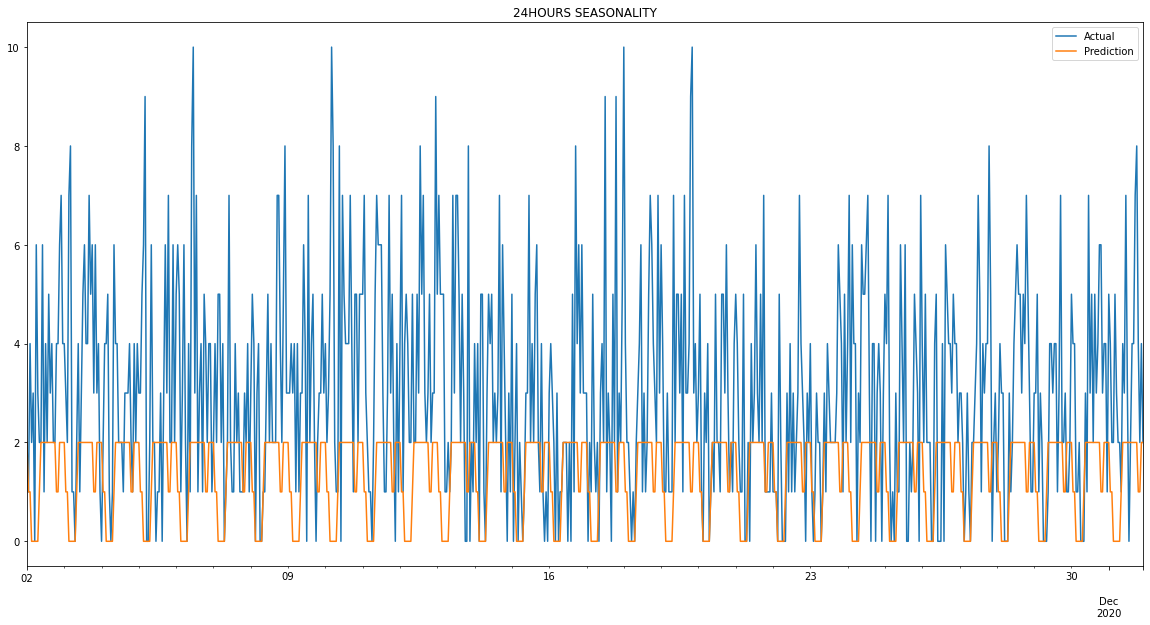

In [83]:
offset = -720*2
my_chain = test_pipe.best_chain
#my_chain = test_pipe.chains[4]
my_chain.predict(pd.Timestamp('2020-01'), pd.Timestamp('2021-01'))
truth = ds['h'].zones[0][DISEASES[0]].rename('Actual')
my_pred = my_chain.prediction.rename('Prediction')
pd.concat([truth, my_pred], axis=1)[offset:720+offset-1].plot(figsize=(20, 10), title='24HOURS SEASONALITY')

Again, the graph shows that the best model blatantly underestimates values in too many cases, even at zone level. Thanks to the MAE metrics! But it does get the highest score:

In [ ]:
# Median seasonality
predictions_z = []
for disease in DISEASES[:20]:
  predictions_z.append(DiseaseTotal(disease))
  scores = [pred.contest_mae for pred in predictions_z]
  print(sum([scores[i]/(i+1) for i in range(len(scores))]))

cross-validation test by zones, quarterly, mean seasonality, 1.093 in sample, 1.128 out of sample. Approach with  prediction of first disease by only 2019 data as AR parameter gives 1.047 out of sample. 

Use of median seasonality improves out-of-sample score to 1.012. 

Prediction of first three diseases by AR 2019 and calculating threir seasonal coefficients using only 2019 data gives best score of 1.007. Note that best models stay the same, only time-series inputs change.

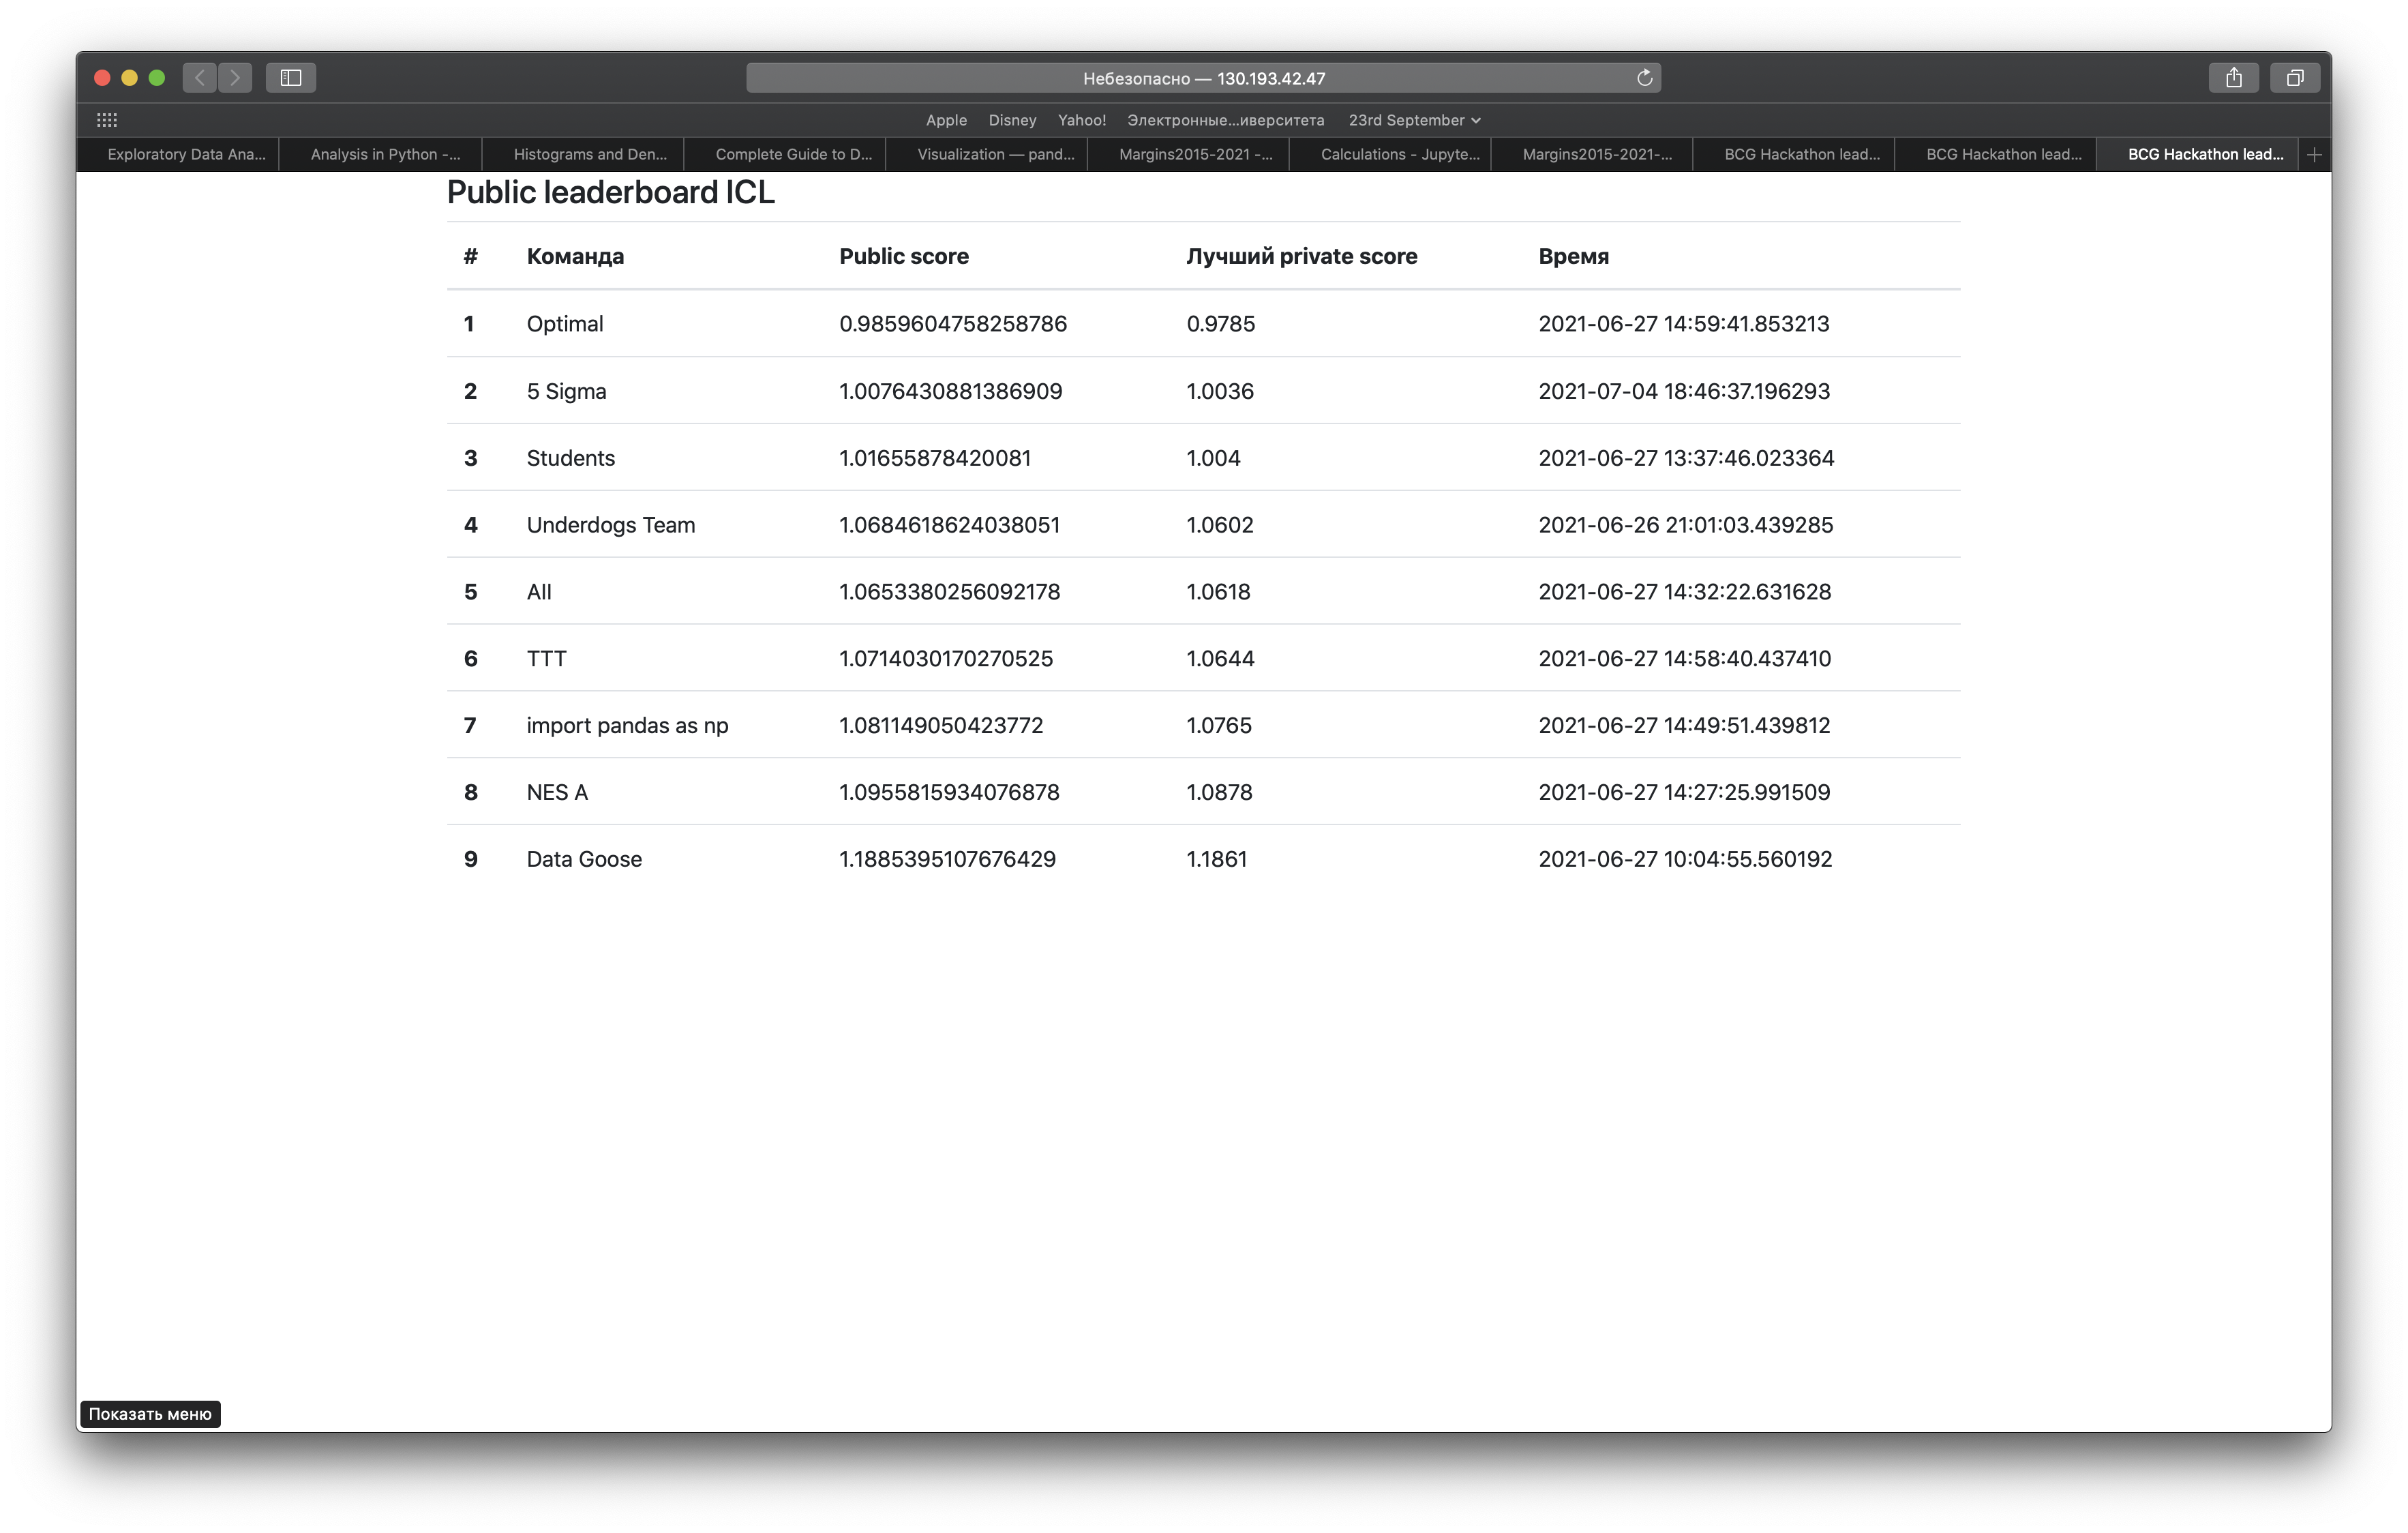

In [88]:
from IPython.display import Image
Image("leaderboard_final.png")

You can see the score on the second place under "5 Sigma" name. It's still not the highest score. The first solution didn't employ any ML algos or median statistics but rather output zeros and ones, the latter only in case if same-hour means of the series was larger than 0.8 (if I understood correctly)

While this custom approach gets the highest metrics for this particular dataset, I don't feel obligated to fine-tune my model to replicate or beat the result. That's because I don't fully understand the reasoning and rationale behind this forecasting method: this threshold function is neither a quantile nor some mean and can behave unpredictably on data with different distributions. So I don't feel it generalizes well to any other datasets.

Thus, I claim my task of getting a good prediction suited for the chosen metrics completed.

# Dealing with a real life problem

Of course, if you are an executive of a real city ambulance service, you want to know the most probable (in the context of the dadaset it's always the same as 50% of all values point and is captured by median) number of calls for medical aid you can get in a particular time. But what might be even more important for you is the maximal or submaximal number of these calls that can happen all at the same time. You MUST have the amount of resources (personnel and appropiately equipped ambulance cars) necessary to promptly meet the demand for help, especially if it's for some type of emergency cause (like heart attack). 

This type of knowledge is better (but not in the best possible way) captured by mean (expected value), which is almost (but not) always greater than the median for statistical distributions with right skewness. And that's the case for distributions of all the diseases as their values are nonnegative and densest around zero with fat right tail. See the example:

<AxesSubplot:>

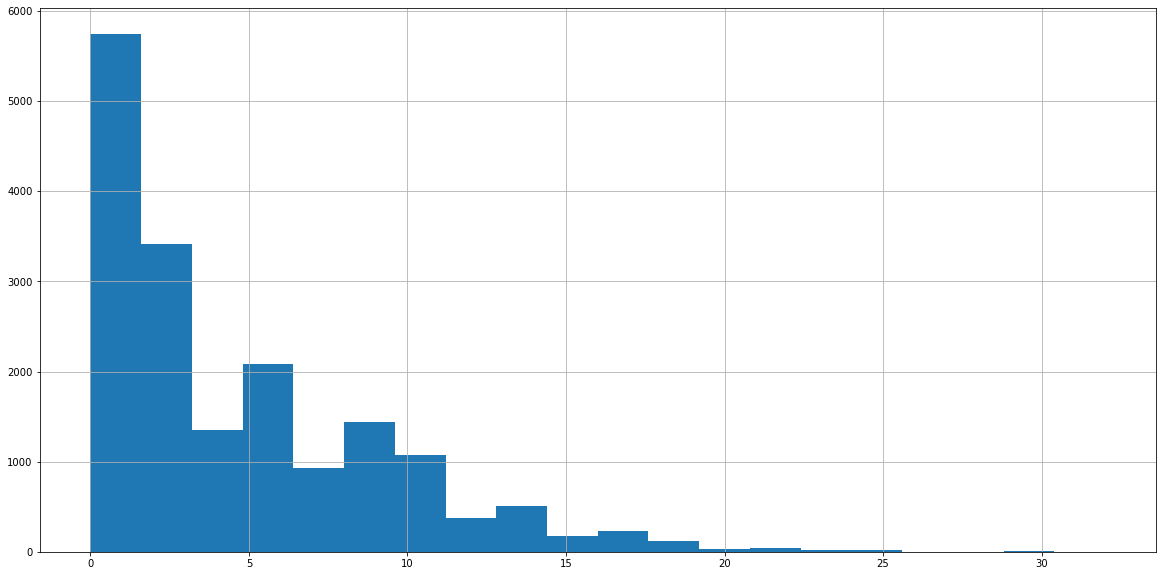

In [132]:
ds['h'].total[DISEASES[0]].hist(bins=20, figsize=(20, 10))

And the metrics which favors mean value is RMSE (root mean squared error). Mean value is the best estimator minimizing RMSE in the class of constant estimators (I'll write a proof later). So, if you want to get most probable number of occurencies, choose MAE metrics, and if you want a slightly higher estimate, accounting for some outliers, take RMSE.

For perspective, consider the following example:
Actual|0|0|1|
:-----:|:-----:|:-----:|:-----:|
Median prediction|0|0|0|
Mean prediction|1/3|1/3|1/3|

Let's pretend that exactly 1 call happens during every three hours, therefore there will be no calls in 2 hours of three. If you'd use median as a predictor, you would chill in a happy oblivion not expecting any calls untill the first one actually happened. But with mean prediction you're aware of non-zero probability of a call at any particular hour and can adjust your resources accordingly. So far, so good.

MAE for median prediction is 1/3 and for the mean is 4/9. RMSE for the median is $\sqrt3/3$ and for the mean is $\sqrt2/3$. These calculations confirm theoretical results that median is better for MAE and mean for RMSE.

Now consider another situation: real distribution of calls is like this: {0, 0, 0, 3}. So in every 4 hours there are 3 calls which all happen at once. Both median (0) and mean (0.75) predictions are not fully adequate in a sense that they don't describe the load which you'll observe every so often and have to deal with.

So, what's the solution? Use 0.8 or 0.9 quantile, which yields the desired value 3 in this scenario. In fact, similar methods (quantile regressions) are old and well known, although not oftently deployed, in econometric science.

The metric, for which a quantile of order $\tau$ with value q is a best estimator, has the following formulae:

MQE (mean quantile error) = $\frac{1}{n}((\tau-1)\sum_{y<q}(y_i-q)+\tau\sum_{y>=q}(y_i-q))$

If $\tau=0.5$, MAE=MQE, and median prediction becomes the best one. Proof of optimality of q for this metrics can be found here: [Quantile_of_a_random_variable](https://en.wikipedia.org/wiki/Quantile_regression#Quantile_of_a_random_variable).

Therefore, I implemented both quantile type of seasonality indices' calculation and the metrics which rewards them for such cases.

In [20]:

# Pipeline to achieve the best actual forecast for some disease (city total) 
import time
from itertools import product, chain as list_concat
from joblib import Parallel, delayed
class PipelineTotal():
    """
    Pipeline for cross-validation and selection of best chain of seasonal 
    models along with train and test parameters
    """
    def __init__(self, disease, period, seasonality_f):
        self.disease = disease
        if seasonality_f == SeasonalModel.get_seasonal_weights:
            metrics_f = ChainedModels.prediction_rmse
        elif seasonality_f == SeasonalModel.get_median_weights:
            print('median')
            metrics_f = ChainedModels.prediction_mae
        else:
            metrics_f = ChainedModels.prediction_mqe
        if period == 'q':
            step = pd.DateOffset(months=3)
        elif period == 'm':
            step = pd.DateOffset(months=1)
        else: 
            step = pd.DateOffset(weeks=1)
        input_ts = ds[period].total[disease]
        train_periods = [0, 1, 2, 4]
        ar_periods = [0, 1, 2, 4]

        #Components of chains:        
        component1 = (
            [SeasonalModel('q')], []
        ) 
        component2 = (
            [SeasonalModel('m')], []
        )   
        component3 = (
            [UniformModel('w')], []
        )
        component4 = (
            [SeasonalModel('h')], 
            [SeasonalModel('d'), SeasonalModel('h')],
            [SeasonalModel('2h'), UniformModel('h')],
            [SeasonalModel('4h'), UniformModel('h')],
            [SeasonalModel('8h'), UniformModel('h')]
        )
        self.chains = []
        for c1, c2, c3, c4, train_per, ar_per in product(
            component1, component2, component3, component4, train_periods, ar_periods
        ):
            self.chains.append(CrossValChain(
                chain_of_models=c1+c2+c3+c4, input_ts=input_ts,
                train_period=train_per, ar_period=ar_per, 
                step=step,
                train_ts=ds['h'].total[disease], 
                calc_func= seasonality_f
            ))
        test_start = pd.Timestamp('2020-01')
        test_stop = pd.Timestamp('2020-12')
        
        # Parallel cross-validation of all chains
        # Joblib copies all objects when creating child processes,
        # so no need to worry about shared concurrent access to same
        # seasonal and uniform models
        n_processes = 16
        # Overhead during start of new procceses if very big due to
        #  copying all models, so it's better to unite them in chunks
        chunks = [
            self.chains[z:z+n_processes] for z in 
            range(0, len(self.chains), n_processes)
        ]

        def envelope(chunk):
            for chain in chunk:
                chain.predict(test_start, test_stop)
                metrics_f(chain, ds['h'].total[disease])
            return chunk        
        start = time.time()
        res = Parallel(n_jobs=n_processes)( delayed(envelope)
        (z) for z in chunks)
        self.chains = list(list_concat(*res))
        #print(res[:5])
        """
        # Cross-validation of all chains (sequential)
        for cnt, chain in enumerate(self.chains):
            if cnt% 50 ==0: print(time.ctime(), 'started chain ', cnt)
            chain.predict(test_start, test_stop)
            chain.prediction_mae(ds['h'].total[disease])
        """
        self.chains.sort(key= lambda x: x.metrics)
        self.best_chain = self.chains[0]
        self.best_metrics = self.best_chain.metrics
        self.chains = self.chains[:20]
        #print(self.contest_mae, self.best_index, disease)

        # Getting predictions for 1q2021
        pred_start = pd.Timestamp('2021-01-01 00:00:00')
        pred_end = pd.Timestamp('2021-04-01 00:00:00')
        base_prediction = self.best_chain.predict(pred_start, pred_end)['1Q2021']                   
        self.q1_2021_pred = base_prediction
        print(time.ctime(), 'metrics:', self.best_metrics, 'seasonality type:', seasonality_f)


## Which type of seasonality is better - median, mean or quantile?

In [40]:
# Helper function to draw a graph of the best model on a monthly time-span
def graph(n_dis=0, offset=4, seas_type='mean', step='q'):
    """
    n_dis: number of a disease to use
    offset: monthly offset from the end of time-series (min. 1)
    seas_type: 'mean', 'median' or 'quantile'. Selects type of seasonality indices
    and appropriate metrics for optimization
    step: time-window for cross-validation
    Returns: Pandas Dataframe with actual values and predictions of the best model
    """
    offset = -720 * offset
    if seas_type == 'mean': model = SeasonalModel.get_seasonal_weights
    elif seas_type == 'median': model = SeasonalModel.get_median_weights
    elif seas_type == 'quantile': model = SeasonalModel.get_quantile_weights
    test_pipe= PipelineTotal(DISEASES[n_dis], period=step, seasonality_f=model)
    print(test_pipe.best_chain.description())
    my_chain = test_pipe.best_chain
    my_chain.predict(pd.Timestamp('2020-01'), pd.Timestamp('2021-01'))
    truth = ds['h'].total[DISEASES[n_dis]].rename('Actual')
    my_pred = my_chain.prediction.rename('Prediction')
    act_pred = pd.concat([truth, my_pred], axis=1)
    act_pred[offset:720+offset-1].plot(figsize=(20, 10), title='24HOURS ' + 
        seas_type.upper() + ' SEASONALITY')
    return act_pred


Quantile order is 0.8 by defaut.

Sat Jul 10 14:27:04 2021 metrics: 4.015549045432544 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 2,     AR (martingale) period: 1, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'SeasonalModel m', 'UniformModel w', 'SeasonalModel d', 'SeasonalModel h']
median
Sat Jul 10 14:27:30 2021 metrics: 2.8657790420753653 seasonality type: <function SeasonalModel.get_median_weights at 0x7f8c47d975e0>
Training period: 1,     AR (martingale) period: 1, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'UniformModel w', 'SeasonalModel 2h', 'UniformModel h']
Sat Jul 10 14:27:56 2021 metrics: 1.2484978519715824 seasonality type: <function SeasonalModel.get_quantile_weights at 0x7f8c47d97550>
Training period: 1,     AR (martingale) period: 2, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'UniformModel w', 'SeasonalModel d', 'SeasonalModel h']


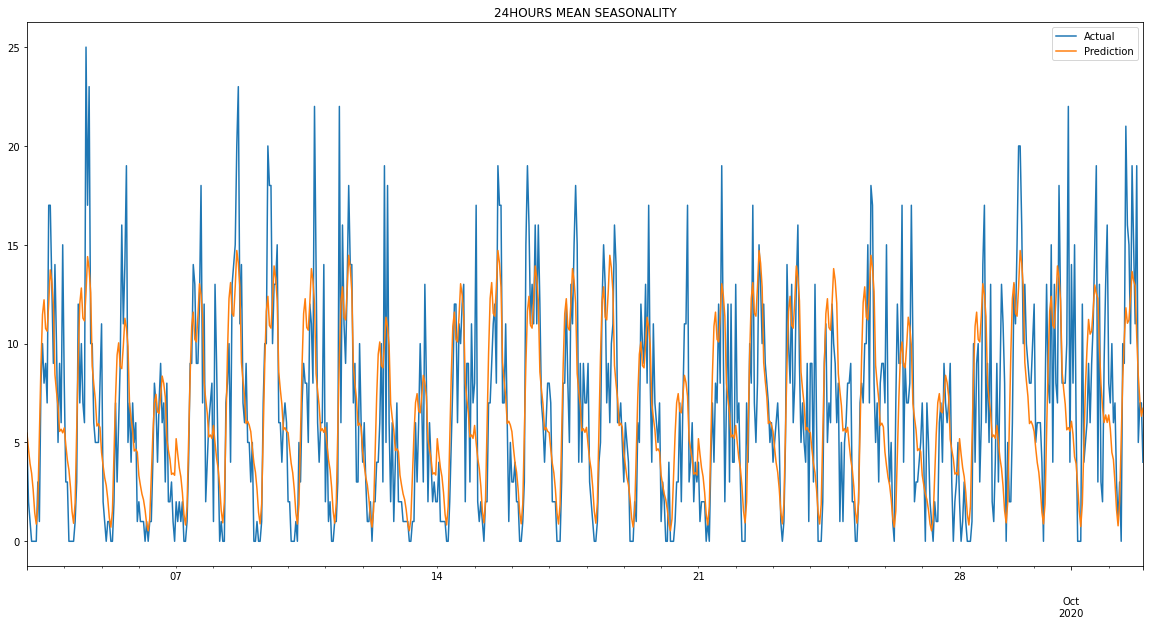

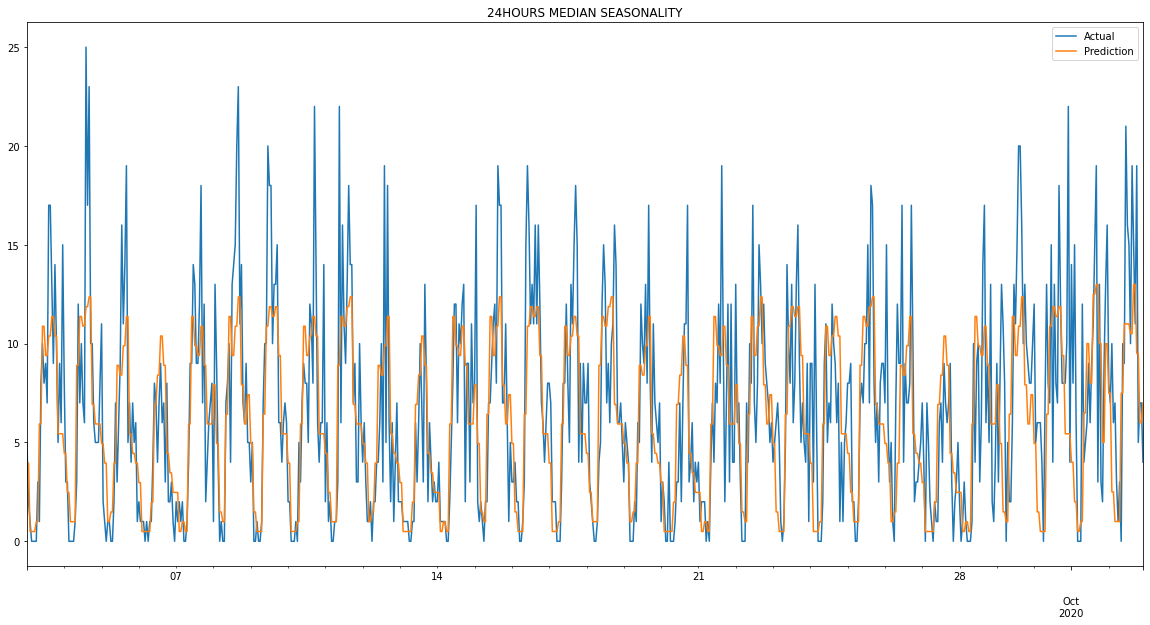

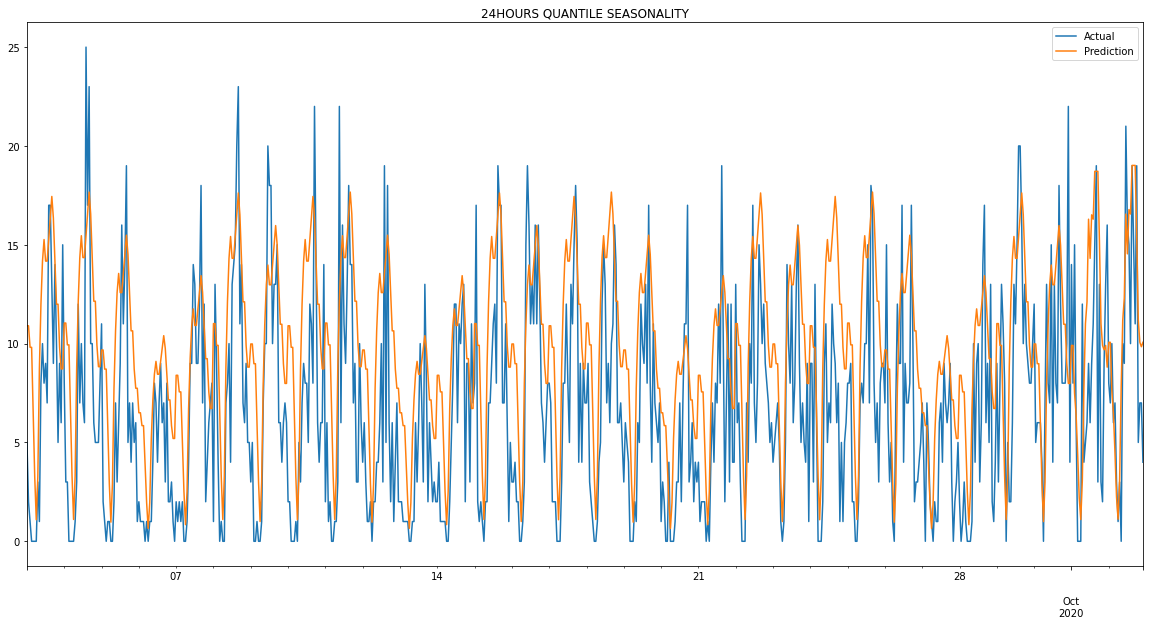

In [41]:
comparison1 = graph(seas_type='mean')
comparison2 = graph(seas_type='median')
comparison3 = graph(seas_type='quantile')

From visual inspection of graphs for the first disease it seems that first two types do well and provide similar results, and quantile seasonality reasonably well predicts peaks of time-series, albeit oftenly overstating them.

Let's check that the models behave similarly well for another month:

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3)

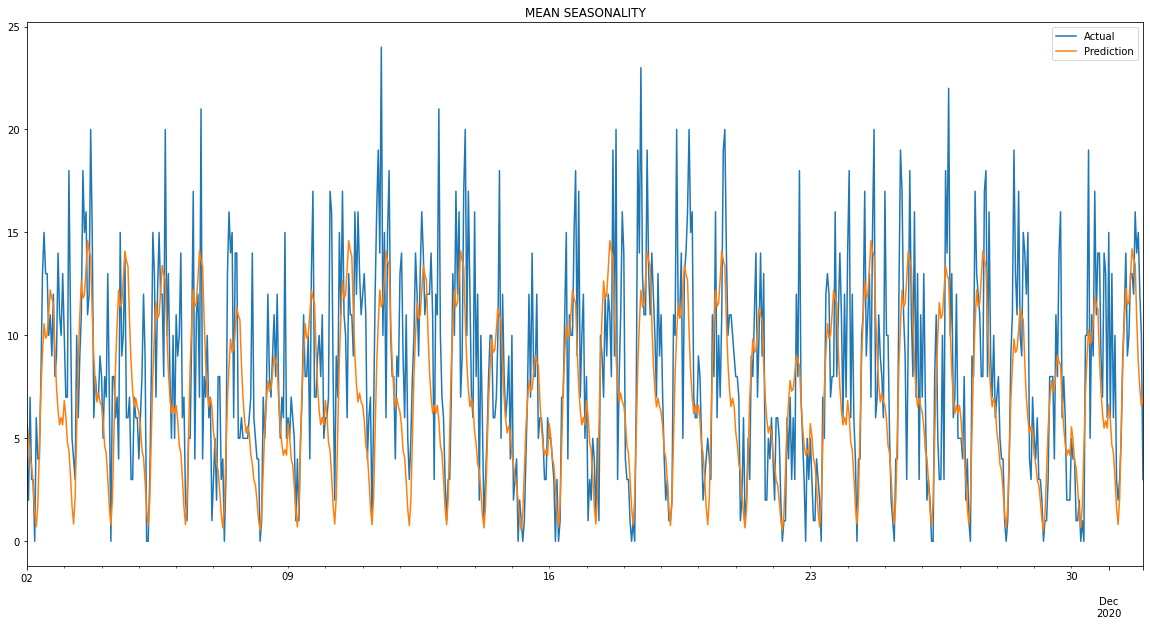

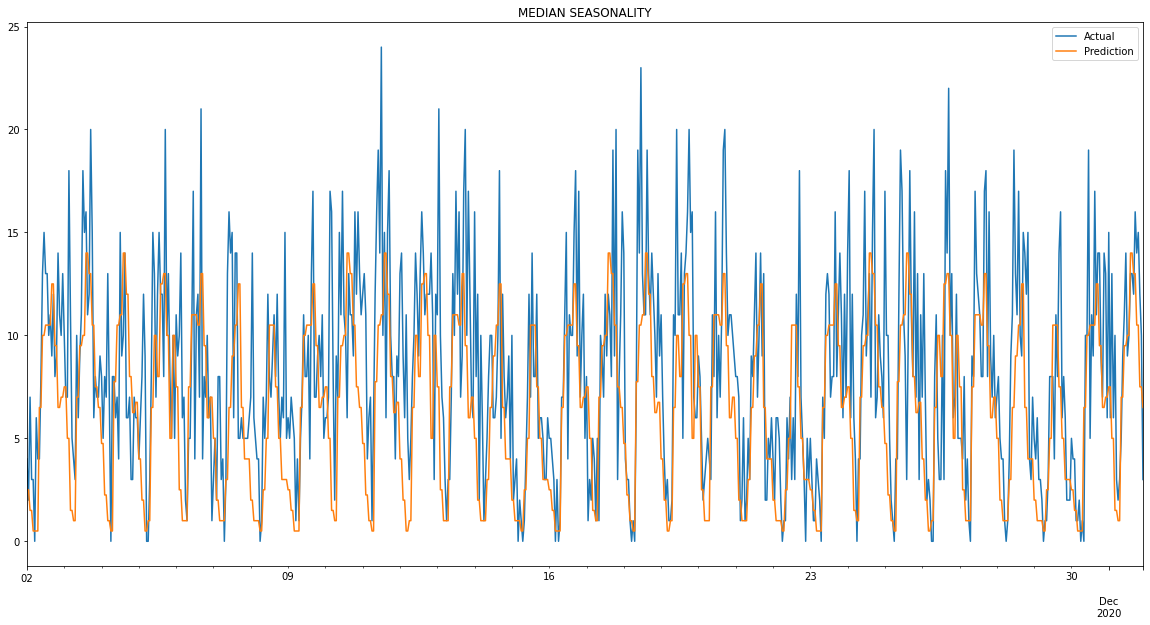

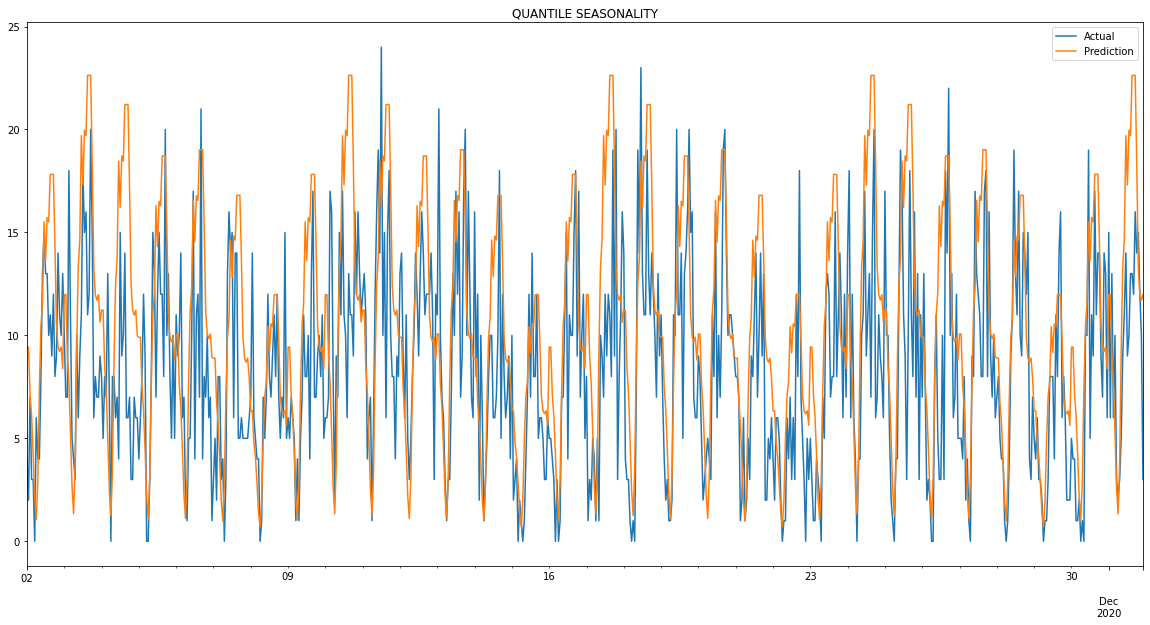

In [35]:
new_offset = -720*2
axs[0] = comparison1[new_offset:720+new_offset-1].plot(figsize=(20, 10), 
title='MEAN SEASONALITY')
axs[1] = comparison2[new_offset:720+new_offset-1].plot(figsize=(20, 10), 
title='MEDIAN SEASONALITY')
axs[2] = comparison3[new_offset:720+new_offset-1].plot(figsize=(20, 10), 
title='QUANTILE SEASONALITY')

## Now let's try out the data for another disease to see sobering difference

Sat Jul 10 14:36:26 2021 metrics: 1.7445186815877975 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 2,     AR (martingale) period: 0, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'SeasonalModel d', 'SeasonalModel h']
median
Sat Jul 10 14:36:53 2021 metrics: 1.3372486226749287 seasonality type: <function SeasonalModel.get_median_weights at 0x7f8c47d975e0>
Training period: 4,     AR (martingale) period: 4, step: <DateOffset: months=3>     models: ['SeasonalModel d', 'SeasonalModel h']
Sat Jul 10 14:37:18 2021 metrics: 0.5252177029729599 seasonality type: <function SeasonalModel.get_quantile_weights at 0x7f8c47d97550>
Training period: 4,     AR (martingale) period: 4, step: <DateOffset: months=3>     models: ['SeasonalModel d', 'SeasonalModel h']


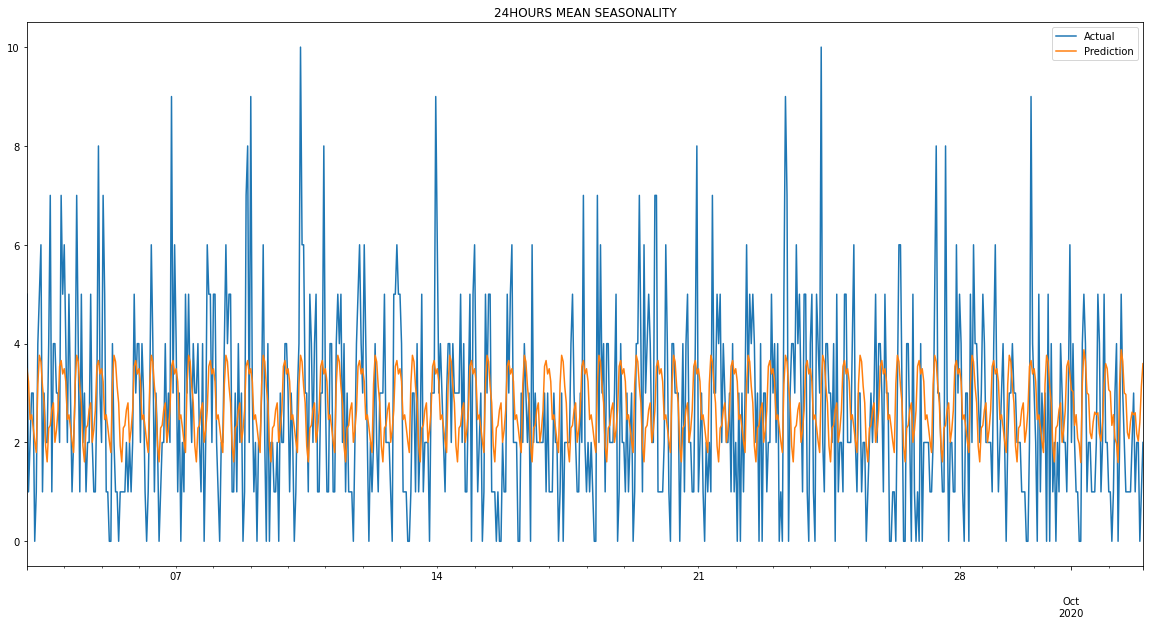

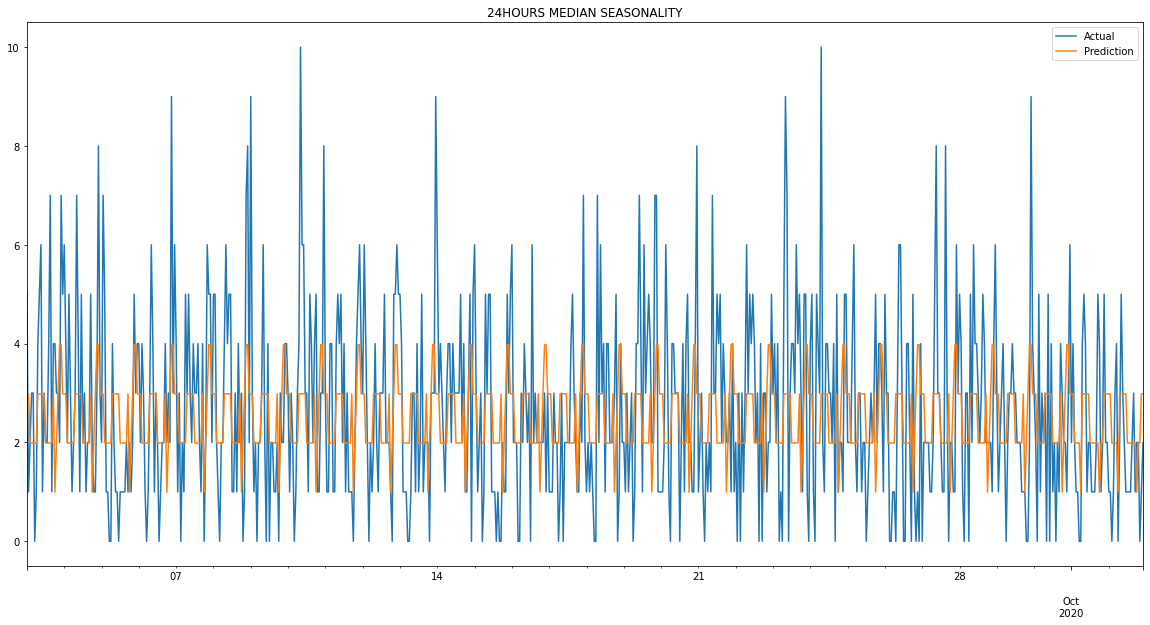

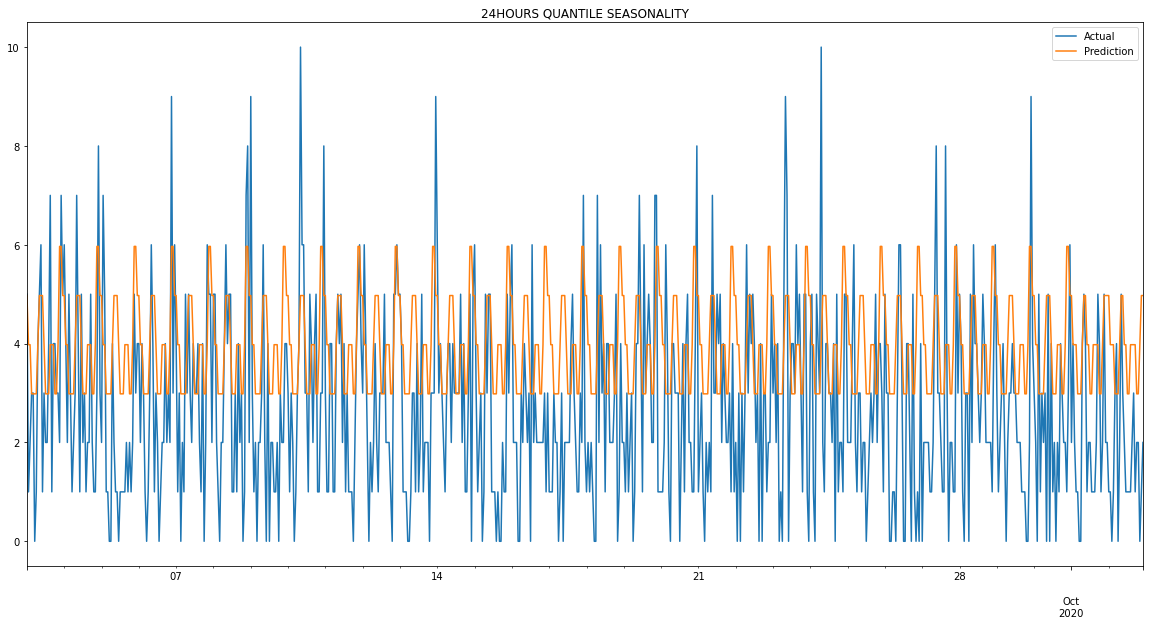

In [42]:
comparison1 = graph(n_dis=1, seas_type='mean')
comparison2 = graph(n_dis=1, seas_type='median')
comparison3 = graph(n_dis=1, seas_type='quantile')

All models don't fit the data very well visually, median seasonality seems too polygon-like and quantile (somewhat expectedly) mistreats bottom half of values on the last graph . Maybe predicting just for a month, not for a full quarter ahead will improve performance?

## Predicting second disease with a monthly time window

Sat Jul 10 14:40:08 2021 metrics: 1.705689101418516 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 4,     AR (martingale) period: 1, step: <DateOffset: months=1>     models: ['SeasonalModel m', 'SeasonalModel d', 'SeasonalModel h']
median
Sat Jul 10 14:41:02 2021 metrics: 1.3304634225978094 seasonality type: <function SeasonalModel.get_median_weights at 0x7f8c47d975e0>
Training period: 4,     AR (martingale) period: 4, step: <DateOffset: months=1>     models: ['SeasonalModel m', 'SeasonalModel d', 'SeasonalModel h']
Sat Jul 10 14:41:53 2021 metrics: 0.5240018681101203 seasonality type: <function SeasonalModel.get_quantile_weights at 0x7f8c47d97550>
Training period: 4,     AR (martingale) period: 1, step: <DateOffset: months=1>     models: ['SeasonalModel m', 'SeasonalModel d', 'SeasonalModel h']


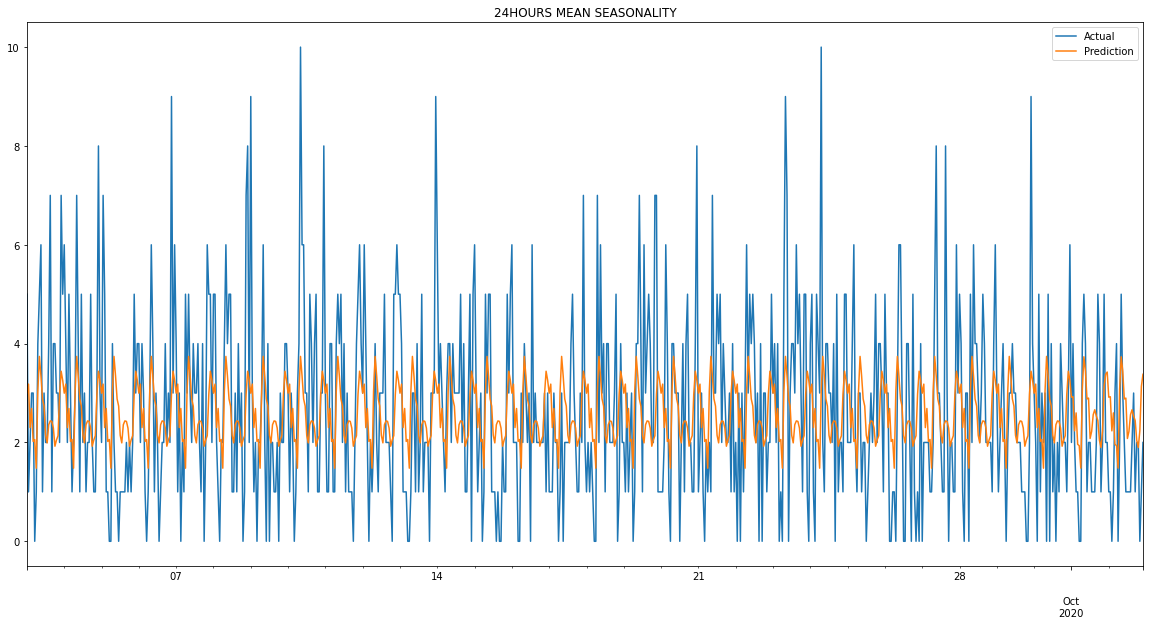

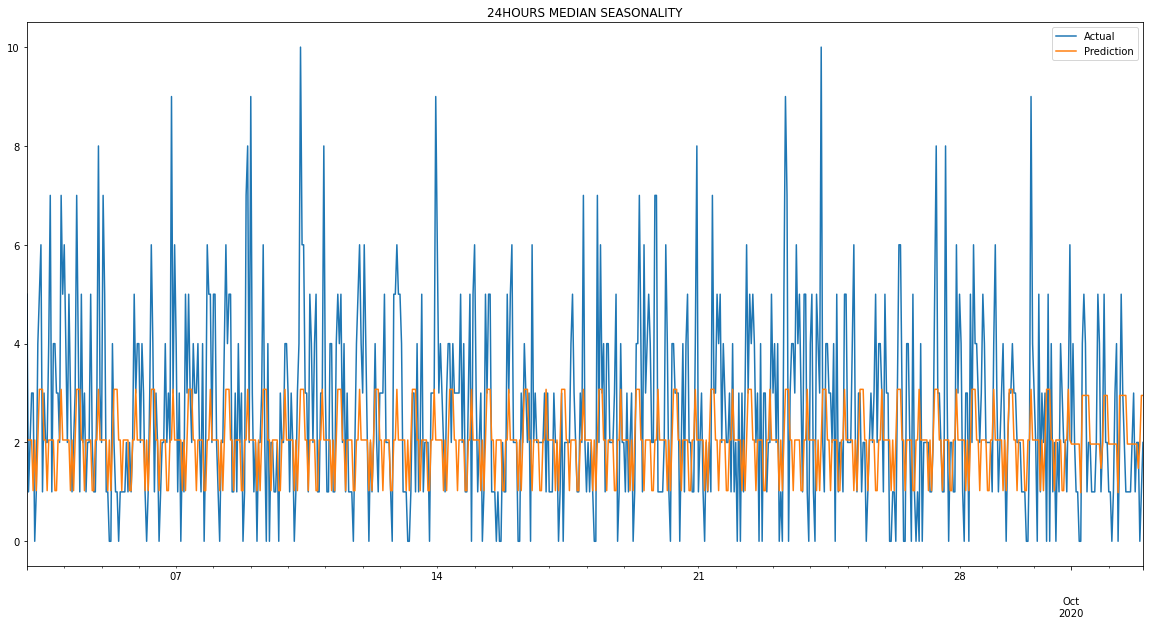

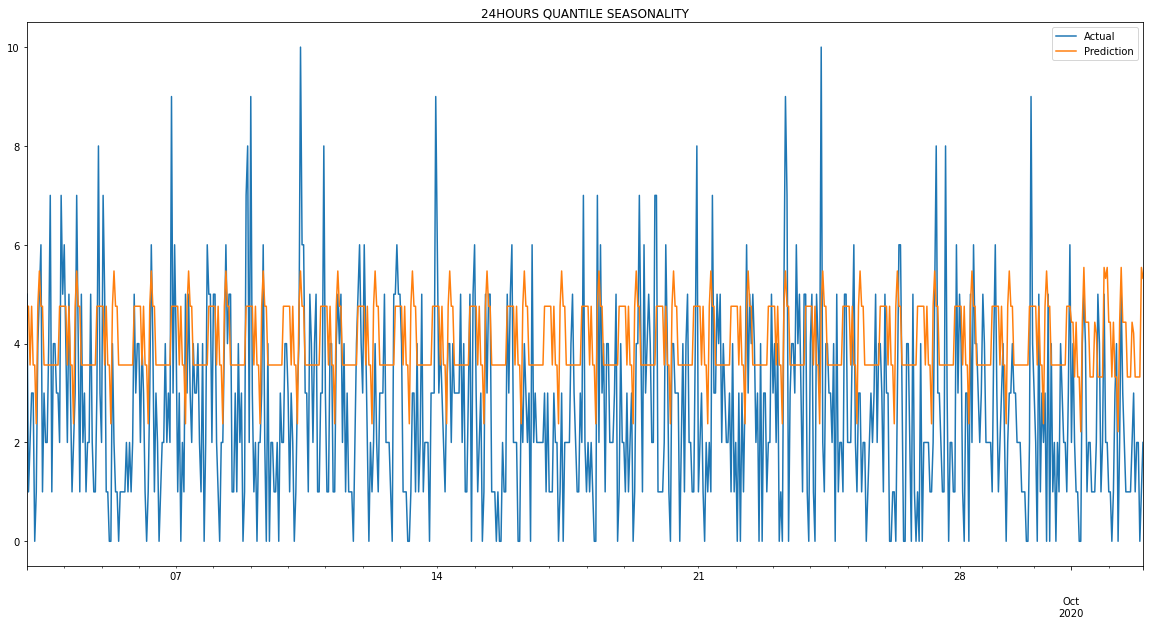

In [43]:
comparison1 = graph(n_dis=1, seas_type='mean', step='m')
comparison2 = graph(n_dis=1, seas_type='median', step='m')
comparison3 = graph(n_dis=1, seas_type='quantile', step='m')

Yes, it does, in a way. Corresponding metrics for each type of seasonality got better. But visually, predicted lines on the graphs didn't become much more appealing.

So let's try the ultimate approach:

## Predicting second disese with a WEEKLY time window

Sat Jul 10 14:44:55 2021 metrics: 1.5333996197983666 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 1,     AR (martingale) period: 1, step: <DateOffset: days=7, weeks=1>     models: ['UniformModel w', 'SeasonalModel h']
median
Sat Jul 10 14:47:52 2021 metrics: 1.1353948082011496 seasonality type: <function SeasonalModel.get_median_weights at 0x7f8c47d975e0>
Training period: 1,     AR (martingale) period: 1, step: <DateOffset: days=7, weeks=1>     models: ['UniformModel w', 'SeasonalModel h']
Sat Jul 10 14:51:05 2021 metrics: 0.42858198744872117 seasonality type: <function SeasonalModel.get_quantile_weights at 0x7f8c47d97550>
Training period: 1,     AR (martingale) period: 1, step: <DateOffset: days=7, weeks=1>     models: ['UniformModel w', 'SeasonalModel h']


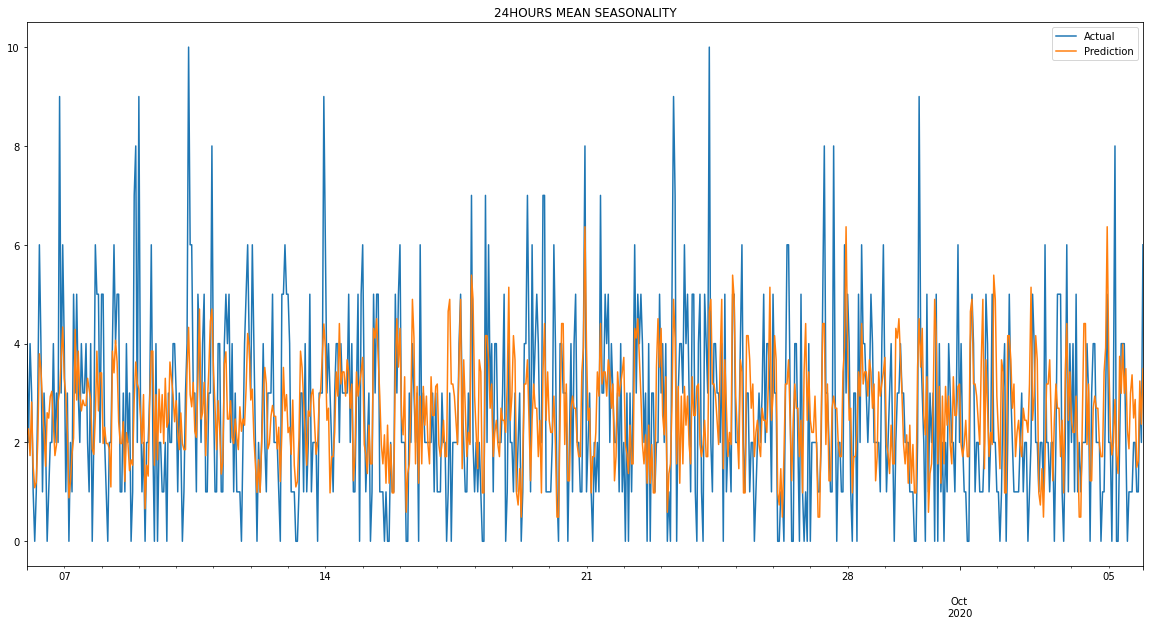

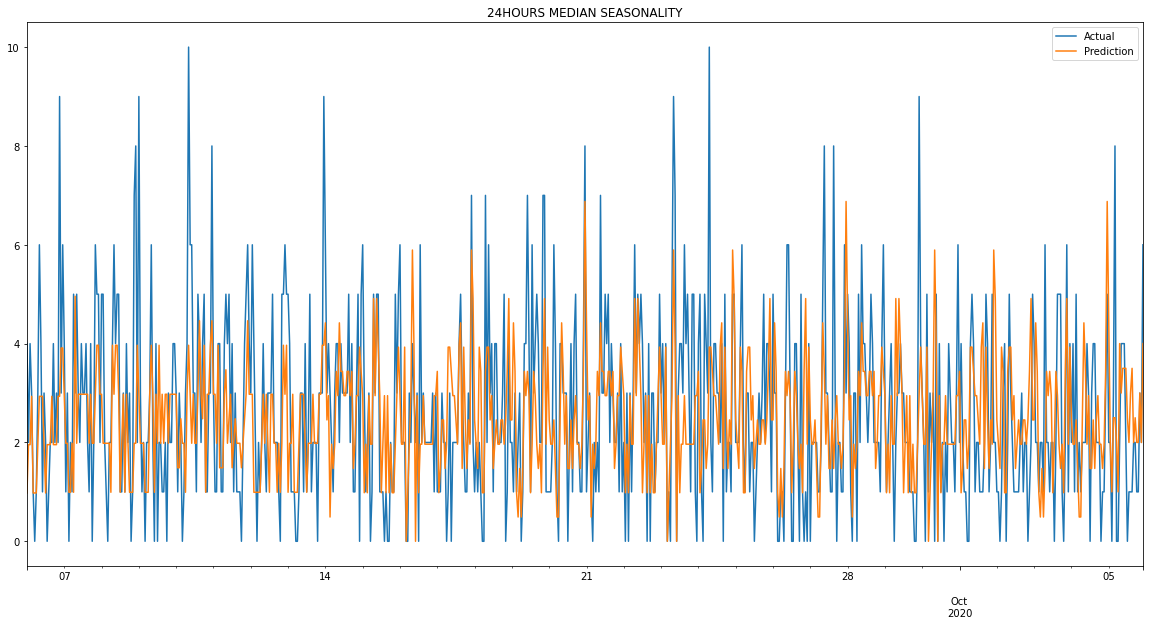

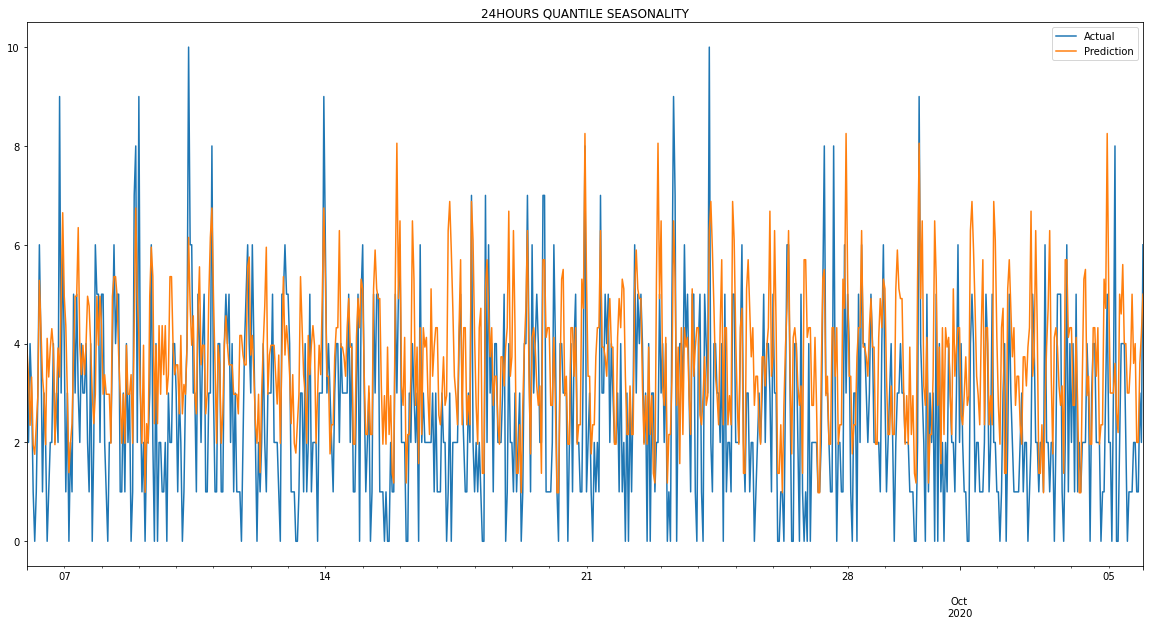

In [44]:
comparison1 = graph(n_dis=1, seas_type='mean', step='w')
comparison2 = graph(n_dis=1, seas_type='median', step='w')
comparison3 = graph(n_dis=1, seas_type='quantile', step='w')

Yes! It really, really got better after switching to predicting just one WEEK, not one QUARTER ahead. Both in terms of visual fitness and metrics reduction.

Don't be scared by long calculation times for weekly models. I didn't bother to trim any unnecessary combinations of Uniform/Seasonal models in pipeline that would reduce the time like tenfold of greater.

## Progression of prediction quality by using smaller time windows on example of mean seasonality:

### Quarterly

Sat Jul 10 14:51:29 2021 metrics: 1.7445186815877975 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 2,     AR (martingale) period: 0, step: <DateOffset: months=3>     models: ['SeasonalModel q', 'SeasonalModel d', 'SeasonalModel h']


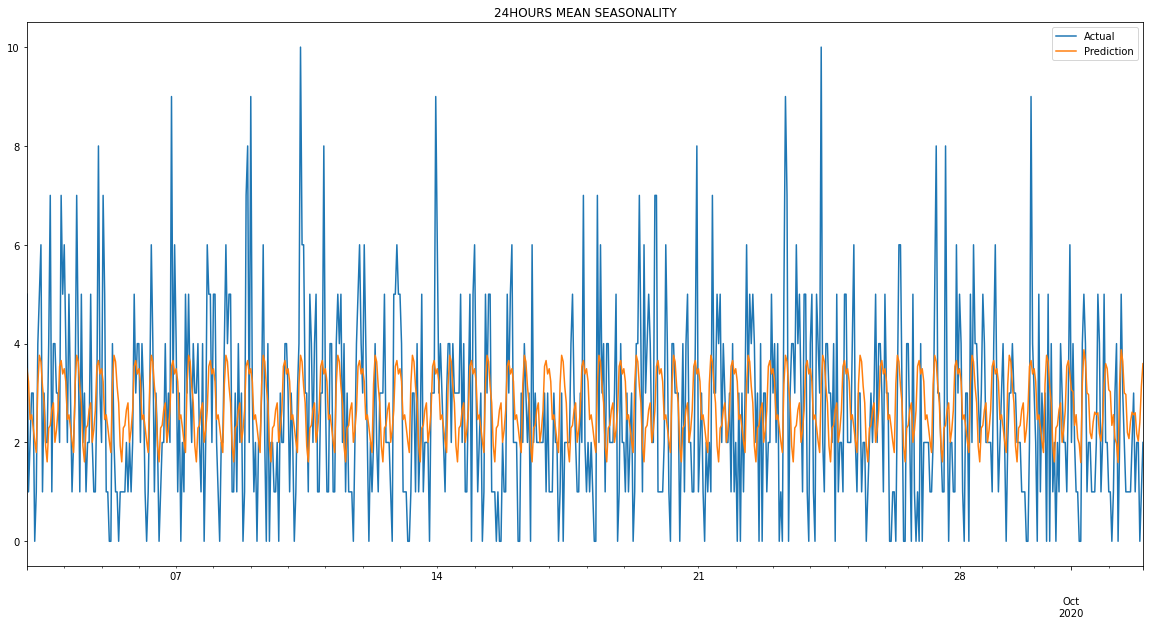

In [45]:
comparison1 = graph(n_dis=1, seas_type='mean', step='q')

Monthly

Sat Jul 10 14:52:20 2021 metrics: 1.705689101418516 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 4,     AR (martingale) period: 1, step: <DateOffset: months=1>     models: ['SeasonalModel m', 'SeasonalModel d', 'SeasonalModel h']


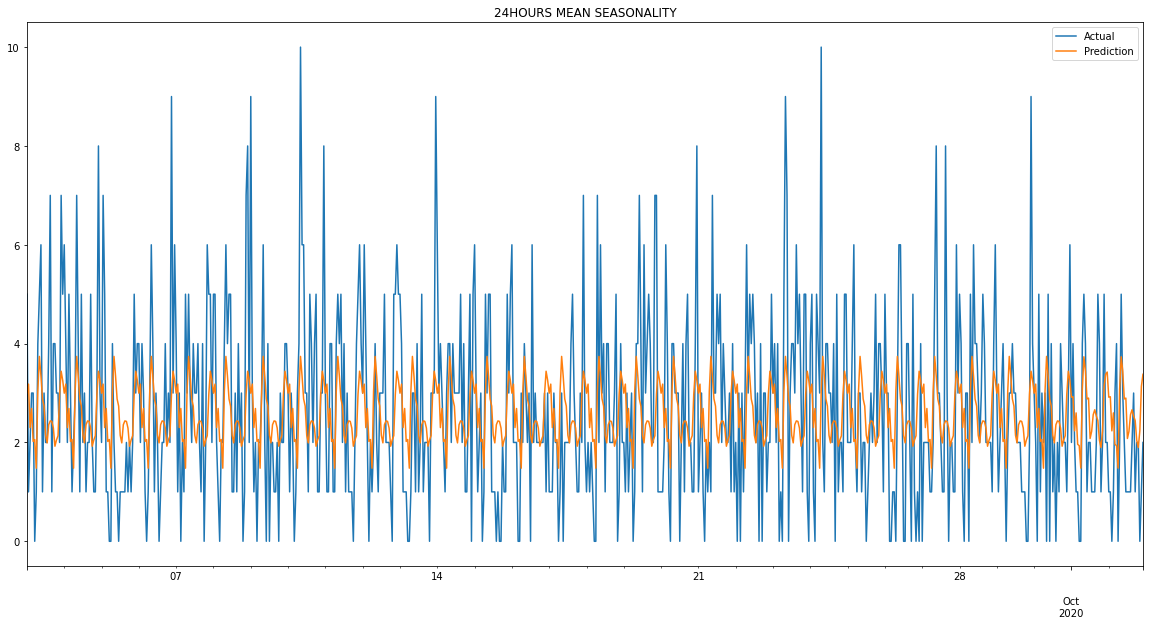

In [46]:
comparison1 = graph(n_dis=1, seas_type='mean', step='m')

### Weekly

Sat Jul 10 14:55:12 2021 metrics: 1.5333996197983666 seasonality type: <function SeasonalModel.get_seasonal_weights at 0x7f8c47d974c0>
Training period: 1,     AR (martingale) period: 1, step: <DateOffset: days=7, weeks=1>     models: ['UniformModel w', 'SeasonalModel h']


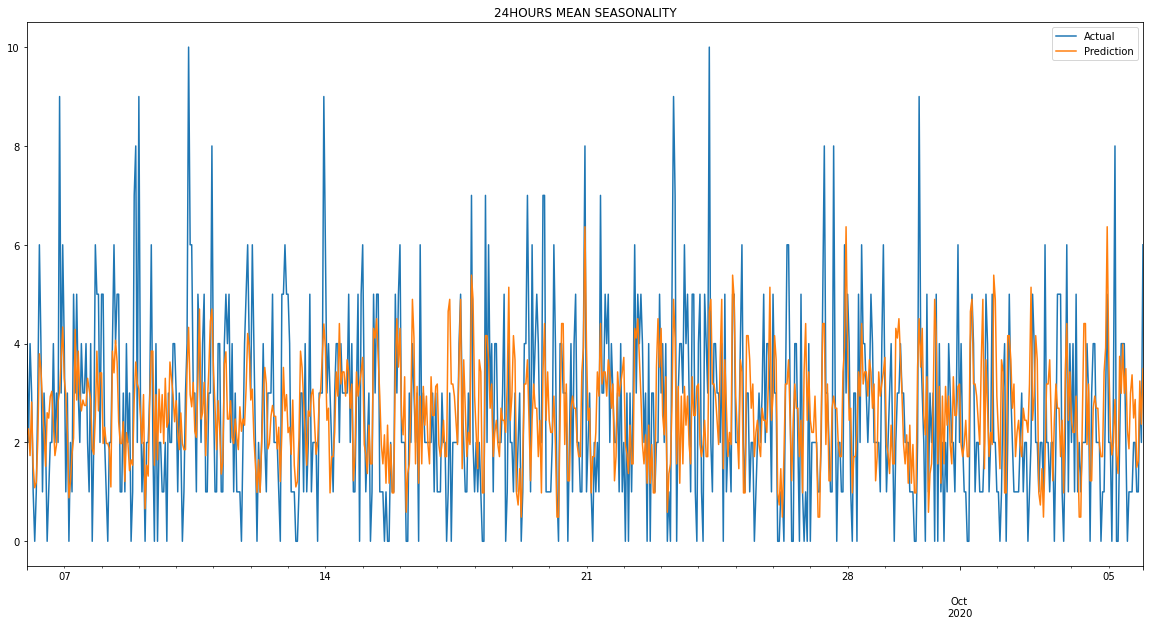

In [47]:
comparison3 = graph(n_dis=1, seas_type='mean', step='w')

# Concluding Thoughts

It follows from common sense that forecasting immediate future is easier than distant. Especially, when we are talking about high precision, high granularity forecasts. But for real world type of problems you frequently need to plan for long ahead (like for a quarter as in the contest task).

Hence, since my framework supports forecasting time windows of different length, from a year all the way down to an hour ahead, I suggest the following approach for this type of problems: combine predictions of models with different time-windows.

For example, use weekly model to get all hourly prediction for one week ahead, then use biweekly model to predict the second week (but not the first). Like-wise, predict third and forth weeks by monthly model, all second month by bimonthly model and, finally, the third month using quaterly time-windowed pipeline. This, likely, will yield the best results both in terms of metrics and actual fitness to the real data.


## Further developments

Be warned that in current state of development my framework will not always give the best short-term prediction using smaller time-windows. For example consider Christmas and New Year holidays week, which is special in so many ways and for many cases. In order to reflect this week correctly, the seasonality component of the model should be trained on a year's worth of data. But that way it contradicts the premise that most recent past captures the nearest future the best. 

So the first revision that I'll make is making possible to train different seasonality models inside one chain on subsets of data of different length. Probably, it will make the model more complicated.

Another way to deal with it is using a voting prediction where one model is trained on a previous year and another just on a previous month or week. A proof-of-concept draft function for this can be found below.

In [20]:
def voting_prediction(pipe, n_predictors):
    #n_predictors = 3
    best_predictors = [pipe.chains[0]]
    curr = 1
    while len(best_predictors) < n_predictors:
        if pipe.chains[curr].mae != best_predictors[-1].mae:
            best_predictors.append(pipe.chains[curr])
        curr += 1
    total_predictions = []
    for best_chain in best_predictors:
        # Getting predictions for 1q2021
        pred_start = pd.Timestamp('2021-01-01 00:00:00')
        pred_end = pd.Timestamp('2021-04-01 00:00:00')
        pipe.voting_prediction = best_chain.predict(pred_start, pred_end)